# Прогнозирование оттока клиентов для оператора "ТелеДом"

**Бизнес-задача**

Оператор связи "ТелеДом" стремится снизить отток клиентов, предлагая персонализированные условия (промокоды, спецпредложения) абонентам с высокой вероятностью расторжения договора.

**Техническая задача**

Разработка модели машинного обучения, которая:
- Анализирует исторические данные клиентов (персональные данные, тарифы, услуги)
- Прогнозирует вероятность прекращения обслуживания
- Выделяет целевую группу для retention-кампаний

**Особенности проекта**
1. **Данные**:
   - Персональные характеристики клиентов
   - Параметры подключенных тарифов
   - История использования услуг

2. **Подход**:
   - Бинарная классификация (уход/сохранение клиента)
   - Оптимизация под бизнес-метрики
   - Интерпретируемость модели для маркетинговых решений

3. **Целевое действие**:
   - Автоматизация выявления "группы риска"
   - Интеграция с CRM для персонализированных предложений

**План работы:**

1. Настройка рабочей среды
2. Загрузка данных
3. Объединение данных
4. Предобработка данных
5. Исследовательский анализ
6. Обучение моделей машинного обучения
7. Анализ моделей
8. Тестирование лучшей модели
9. Общий вывод и рекомендации заказчику 

## Настройка рабочей среды

In [1]:
# Удаление текущих версий
!pip uninstall pandas catboost -y -q

# Установка специфичных версий
!pip install pandas==1.5.3 catboost==1.2 -q

!pip install phik -q

In [2]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

from scipy.stats import loguniform, randint


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score  

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
RANDOM_STATE = 210425

In [4]:
# настройка среды для работы
# зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.3f}'.format)

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# Сброс ограничений на число строк
pd.set_option('display.max_rows', None)

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

## Загрузка данных

In [6]:
# Словарь для хранения DataFrame
data = {}

# Загрузка каждого файла
for name, file_name in file_names.items():
    main_path = os.path.join(base_path, file_name)
    loaded = False
    
    # Проверяем основной путь
    if os.path.exists(main_path):
        try:
            data[name] = pd.read_csv(main_path)
            print(f" Основной файл загружен")
            loaded = True
        except Exception as e:
            print(f" Ошибка при загрузке основного файла: {e}")
    
    # Если в основном пути нет, проверяем альтернативные 
    if not loaded and name in alt_paths:
        for alt_path in alt_paths[name]:
            if os.path.exists(alt_path):
                try:
                    data[name] = pd.read_csv(alt_path)
                    print(f" Альтернативный файл загружен")
                    loaded = True
                    break
                except Exception as e:
                    print(f" Ошибка при загрузке альтернативного файла: {e}")
    
    if not loaded:
        print(f" Не удалось загрузить файл для {name}")

# Создаем переменные для загруженных данных
for name in file_names:
    if name in data:
        globals()[f"{name}_df"] = data[name]

# Проверка результатов
loaded_count = len(data)
total_count = len(file_names)
print(f"\nЗагружено {loaded_count} из {total_count} файлов:")
for name in file_names:
    status = "OK" if name in data else "Error"
    print(f"{status} {name}")

 Основной файл загружен
 Основной файл загружен
 Основной файл загружен
 Основной файл загружен

Загружено 4 из 4 файлов:
OK contract
OK personal
OK internet
OK phone


In [7]:
def get_info(data):
    if data is None:
        print("Датасет пуст (None).")
        return

    try:
        print("Первые 5 строк:")
        display(data.head())

        print("\nОбщая информация:")
        data.info()

        # Статистики для числовых колонок (если они есть)
        numeric_cols = data.select_dtypes(include=['number']).columns
        if len(numeric_cols) > 0:
            print("\nОсновные статистики (числовые колонки):")
            display(data.describe(include=['number']))
        else:
            print("\nЧисловые колонки отсутствуют.")

        # Статистики для категориальных колонок (если они есть)
        object_cols = data.select_dtypes(include=['object', 'category']).columns
        if len(object_cols) > 0:
            print("\nСтатистики для категориальных колонок:")
            display(data.describe(include=['object', 'category']))

        print("\nКоличество явных дубликатов:", data.duplicated().sum())
        print("\nКоличество пропусков:")
        print(data.isna().sum())

    except Exception as e:
        print(f"Ошибка при выводе информации: {e}")

In [8]:
for df_name, df in data.items():
    print(f"\n{'='*50}")
    print(f"Анализ датафрейма: {df_name.upper()}")
    print(f"{'='*50}")
    get_info(df)


Анализ датафрейма: CONTRACT
Первые 5 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.850,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.700,353.5



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Основные статистики (числовые колонки):


,MonthlyCharges
count,"7,043.000"
mean,64.762
std,30.090
min,18.250
25%,35.500
50%,70.350
75%,89.850
max,118.750



Статистики для категориальных колонок:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,
freq,1,366,5942,3875,4171,2365,11



Количество явных дубликатов: 0

Количество пропусков:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Анализ датафрейма: PERSONAL
Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Основные статистики (числовые колонки):


,SeniorCitizen
count,"7,043.000"
mean,0.162
std,0.369
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000



Статистики для категориальных колонок:


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,7590-VHVEG,Male,No,No
freq,1,3555,3641,4933



Количество явных дубликатов: 0

Количество пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Анализ датафрейма: INTERNET
Первые 5 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Числовые колонки отсутствуют.

Статистики для категориальных колонок:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Количество явных дубликатов: 0

Количество пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Анализ датафрейма: PHONE
Первые 5 строк:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Числовые колонки отсутствуют.

Статистики для категориальных колонок:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Количество явных дубликатов: 0

Количество пропусков:
customerID       0
MultipleLines    0
dtype: int64


contract 
- 7043 строк
- все ID уникальные
- пропусков и явных дубликатов нет
- BeginDate - object -надо datetime
- TotalCharges -  object - надо тип float
- MonthlyCharges - высокое стандартное отклонение (в половину меньше среднего)

PERSONAL
- 7043 строк
- все ID уникальные
- пропусков и явных дубликатов нет
- типы данных корректные

INTERNET
- 5517 строк
- все ID уникальные
- пропусков и явных дубликатов нет
- типы данных корректные

PHONE
- 6361 строк
- все ID уникальные
- пропусков и явных дубликатов нет
- типы данных корректные

Вывод:
- данные соответствуют описанию,
- названия колонок нужно преобразовать в соответствии с правилами хорошего стиля,
- преобразовать типы данных


## Объединение датасетов

contract_df является основным, и нам нужно сохранить только тех клиентов, которые присутствуют в нём, а к нему добавлять информацию из других таблиц при совпадении по customer_id. 

In [9]:
dfs = [globals()[f"{name}_df"] for name in file_names]

In [10]:
df = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='left'), dfs)

In [11]:
df.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No


In [12]:
print(f"Объединённый датафрейм: {df.shape}")

Объединённый датафрейм: (7043, 20)


In [13]:
df.isna().mean()

customerID         0.000
BeginDate          0.000
EndDate            0.000
Type               0.000
PaperlessBilling   0.000
PaymentMethod      0.000
MonthlyCharges     0.000
TotalCharges       0.000
gender             0.000
SeniorCitizen      0.000
Partner            0.000
Dependents         0.000
InternetService    0.217
OnlineSecurity     0.217
OnlineBackup       0.217
DeviceProtection   0.217
TechSupport        0.217
StreamingTV        0.217
StreamingMovies    0.217
MultipleLines      0.097
dtype: float64

После объединения возникли пропуски. Они означают, что клиент не пользуется этими услугами. Обработаем их дальше

In [14]:
# проверим неявные дубликаты
df.duplicated(subset='customerID').sum()

0

## Предобработка данныx

### Приводим названия столбцов в соответствии с правилами хорошего стиля

In [15]:
def normalize_column_name(col):
    # Заменяем пробелы и точки на подчёркивания
    col = re.sub(r'[\s.]+', '_', col)
    # Добавляем _ перед заглавными буквами (кроме начала слова и последовательных заглавных)
    col = re.sub(r'(?<!^)(?<![A-Z_])([A-Z])', r'_\1', col)
    # Приводим к нижнему регистру
    return col.lower()

In [16]:
def normalize_dataframe_columns(df):
    df.columns = [normalize_column_name(col) for col in df.columns]
    return df

In [17]:
# Применяем нормализацию к объединённому датафрейму
df = normalize_dataframe_columns(df)

# Проверяем результат
print("Обновлённые названия столбцов:")
print(df.columns.tolist())

Обновлённые названия столбцов:
['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


### Изменение типов данных

In [18]:
# Функция проверки, можно ли строку преобразовать в datetime
def is_not_date(val):
    try:
        pd.to_datetime(val)
        return False
    except:
        return True

In [19]:
# Применим функцию к столбцу begin_date и отфильтруем проблемные строки
invalid_begin_date = df[df['begin_date'].apply(is_not_date)]

# Выводим количество и сами строки
print(f"Количество некорректных дат: {len(invalid_begin_date)}")

Количество некорректных дат: 0


In [20]:
# Преобразование колонки begin_date в datetime
df['begin_date'] = pd.to_datetime(df['begin_date'])

# Проверка результатов
print(f"Тип данных begin_date: {df['begin_date'].dtype}")
print(f"Количество значений NaT: {df['begin_date'].isna().sum()}")

Тип данных begin_date: datetime64[ns]
Количество значений NaT: 0


In [21]:
# Применим функцию к столбцу end_date и отфильтруем проблемные строки
invalid_end_date = df[df['end_date'].apply(is_not_date)]

In [22]:
# Выводим количество и сами строки
print(f"Количество некорректных дат: {len(invalid_end_date)}")

Количество некорректных дат: 5942


In [23]:
# Выводим проблемные строки
invalid_end_date[['customer_id', 'end_date']].head(3)

,customer_id,end_date
0,7590-VHVEG,No
1,5575-GNVDE,No
2,3668-QPYBK,No


Сравним количество строк, равных No с количеством проблемных строк

In [24]:
print(f"Количество строк равных 'No': {(df['end_date'] == 'No').sum()}")

Количество строк равных 'No': 5942


Все проблемные строки равны No. 

Создадим новый признак - is_active, который будет содержать информацию о том, является ли договор действующим. Это наш таргет.

In [25]:
# Применяем логику: если 'end_date' == 'No', то is_active = True, иначе False
df['is_active'] = df['end_date'].apply(lambda x: x == 'No')

print(df['is_active'].dtype)  # Проверим тип данных

bool


In [26]:
df[['end_date', 'is_active']].head(10)

,end_date,is_active
0,No,True
1,No,True
2,No,True
3,No,True
4,No,True
5,No,True
6,No,True
7,No,True
8,No,True
9,2017-05-01,False


In [27]:
# Преобразование колонки end_date в datetime
# Если не удаётся распознать значение как дату — заменить его на NaT (Not a Time)
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Проверим тип данных 
print(f"Тип данных end_date: {df['end_date'].dtype}")
# Посмотрим, сколько значений стало NaT
print(f"Количество значений NaT (активные клиенты): {df['end_date'].isna().sum()}")

Тип данных end_date: datetime64[ns]
Количество значений NaT (активные клиенты): 5942


In [28]:
# Преобразование колонки total_charges в numeric

try:
    df['total_charges'] = pd.to_numeric(df['total_charges'])
    print("Все значения преобразованы успешно")
except Exception as e:
    print(f"Ошибка преобразования: {e}")

Ошибка преобразования: Unable to parse string " " at position 488


In [29]:
# Найдём строки, которые не удалось преобразовать
problems = df[pd.to_numeric(df['total_charges'], errors='coerce').isna()]

print("\nКоличество проблемных строк:", problems.shape[0])
print(f"Проблемные значения: {problems['total_charges'].unique()}")


Количество проблемных строк: 11
Проблемные значения: [' ']


In [30]:
problems.head(11)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_active
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.550,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,True
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.250,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,True
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.850,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,True
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.750,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.050,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,True
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.850,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,True
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.350,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.000,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,True
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.700,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,True
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.350,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,True


Во всех строках пропущенные значениями в столбце total_charges связаны с тем, что дата начала договора (begin_date) равна дате актуальности данных — 1 февраля 2020 года. Это значит, что договор только начался, и еще не было никаких начислений, поэтому total_charges по логике равен нулю. 

Заменим пропуски total_charges на 0.0 только для тех строк, где begin_date = '2020-02-01'.

In [31]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce').fillna(0.0)

In [32]:
df['total_charges'].dtype

dtype('float64')

In [33]:
# Проверка общего количества пропусков в total_charges
df['total_charges'].isna().sum()

0

Вывод:
- изменили типы данных begin_date и end_date и создали новый признак is_active (целевой),
- изменили тип данных total_charges и обработали пропуски в нем.

### Обработка пропусков и создание новых признаков

In [34]:
df.isna().mean()

customer_id         0.000
begin_date          0.000
end_date            0.844
type                0.000
paperless_billing   0.000
payment_method      0.000
monthly_charges     0.000
total_charges       0.000
gender              0.000
senior_citizen      0.000
partner             0.000
dependents          0.000
internet_service    0.217
online_security     0.217
online_backup       0.217
device_protection   0.217
tech_support        0.217
streaming_tv        0.217
streaming_movies    0.217
multiple_lines      0.097
is_active           0.000
dtype: float64

В end_date 84,4% пропусков - это активные клиенты. Мы уже создали новый признак, который  содержит информацию об активных клиентах.\
Создадим еще один новый признак, который будет содержать информацию о продолжительности договора в днях.

In [35]:
# Фиксированная дата актуальности информации
reference_date = pd.to_datetime('2020-02-01')

# Вычисляем продолжительность: если end_date — NaT, то используем reference_date
df['contract_duration_days'] = (
    df['end_date'].fillna(reference_date) - df['begin_date']
).dt.days

In [36]:
df[['customer_id', 'begin_date', 'end_date', 'contract_duration_days']].head(2)

,customer_id,begin_date,end_date,contract_duration_days
0,7590-VHVEG,2020-01-01,NaT,31
1,5575-GNVDE,2017-04-01,NaT,1036


In [37]:
# Проверим, что дата начала контракта не позже актуальной даты
invalid_start_dates = df[df['begin_date'] > reference_date]

# Если есть строки с неправильной датой начала, выведем их
if not invalid_start_dates.empty:
    print(f"Неверные даты начала контракта (позже {reference_date}):")
    print(invalid_start_dates[['customer_id', 'begin_date']])
else:
    print(f"Все даты начала контракта корректны и не позже {reference_date}.")

Все даты начала контракта корректны и не позже 2020-02-01 00:00:00.


Из признака end_date мы создали 2 новых признака. Сам признак end_date мы не будем использовать для построения модели.

Признаки, отражающие подключение к интернет-услугам, содержат около 21.7% пропусков, а признак, связанный с телефонной связью — около 9.7% пропусков.

Согласно информации от заказчика, отсутствие информации об услуге означает, что клиент ей не пользуется. Однако важно различать два случая:

1. Клиент в целом не пользуется интернетом или телефонией — тогда для него не могут быть указаны никакие сопутствующие услуги.

2. Клиент пользуется интернетом, но отказался от отдельных сервисов, таких как, например, антивирус или облачное хранилище.

Чтобы не потерять это различие, мы не будем заменять пропуски на 'No' или 0, а введём специальное значение 'not_available'. Это позволит в дальнейшем корректно формировать признаки, связанные с количеством подключенных услуг.

In [38]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'is_active',
       'contract_duration_days'],
      dtype='object')

In [39]:
internet_servicies = ['internet_service', 'online_security', 'online_backup', 
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'
                     ]
phone_servicies = [ 'multiple_lines']
all_servicies = internet_servicies + phone_servicies


# Заменим пропуски на 'not_availabel'
for col in all_servicies:
    df[col] = df[col].fillna('not_available')

In [40]:
df.isna().mean()

customer_id              0.000
begin_date               0.000
end_date                 0.844
type                     0.000
paperless_billing        0.000
payment_method           0.000
monthly_charges          0.000
total_charges            0.000
gender                   0.000
senior_citizen           0.000
partner                  0.000
dependents               0.000
internet_service         0.000
online_security          0.000
online_backup            0.000
device_protection        0.000
tech_support             0.000
streaming_tv             0.000
streaming_movies         0.000
multiple_lines           0.000
is_active                0.000
contract_duration_days   0.000
dtype: float64

In [41]:
df[all_servicies].head(2)

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,DSL,No,Yes,No,No,No,No,not_available
1,DSL,Yes,No,Yes,No,No,No,No


Рассмотрим признак 'internet_service' -  Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).\
Проверим уникальные значения после добавления "заглушки".

In [42]:
df['internet_service'].value_counts()

Fiber optic      3096
DSL              2421
not_available    1526
Name: internet_service, dtype: int64

Добавим новый бинарный признак 'has_internet' на основании данных 'internet_service'.

In [43]:
# Создание флага has_internet (булевый тип)
df['has_internet'] = df['internet_service'].isin(['DSL', 'Fiber optic']).astype(bool)

# Проверим тип данных
print(df['has_internet'].dtype) 

bool


In [44]:
df[['has_internet', 'internet_service']].tail(6)

,has_internet,internet_service
7037,False,not_available
7038,True,DSL
7039,True,Fiber optic
7040,True,DSL
7041,True,Fiber optic
7042,True,Fiber optic


Рассмотрим признаки 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'. Это дополнительные услуги для тех, у кого есть интернет подключение.\
Добавим новый признак - количество услуг для интернет пользователей.

In [45]:
# Список дополнительных интернет-услуг
internet_addon_services = [
    'online_security', 'online_backup',
    'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies'
]

# Подсчёт количества услуг (учитываем только 'Yes')
df['internet_services_count'] = df[internet_addon_services].apply(lambda row: sum(val == 'Yes' for val in row), axis=1)

In [46]:
df[internet_addon_services + ['internet_services_count']].head()

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,internet_services_count
0,No,Yes,No,No,No,No,1
1,Yes,No,Yes,No,No,No,2
2,Yes,Yes,No,No,No,No,2
3,Yes,No,Yes,Yes,No,No,3
4,No,No,No,No,No,No,0


In [47]:
# проверим есть ли клиенты, у которых не подключен интернет, но есть интернет-услуги
df[(df['has_internet'] == 0) & (df['internet_services_count'] > 0)]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_active,contract_duration_days,has_internet,internet_services_count


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              7043 non-null   object        
 1   begin_date               7043 non-null   datetime64[ns]
 2   end_date                 1101 non-null   datetime64[ns]
 3   type                     7043 non-null   object        
 4   paperless_billing        7043 non-null   object        
 5   payment_method           7043 non-null   object        
 6   monthly_charges          7043 non-null   float64       
 7   total_charges            7043 non-null   float64       
 8   gender                   7043 non-null   object        
 9   senior_citizen           7043 non-null   int64         
 10  partner                  7043 non-null   object        
 11  dependents               7043 non-null   object        
 12  internet_service         7043 non-

Пропуски обработаны.\
Заменим типы данных на bool в соответствующих признаках.

In [49]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_active,contract_duration_days,has_internet,internet_services_count
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.850,31.040,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,not_available,True,31,True,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.950,"2,071.840",Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,True,1036,True,2
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.850,226.170,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,True,123,True,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.300,"1,960.600",Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,not_available,True,1371,True,3
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.700,353.500,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,True,153,True,0


In [50]:
# Признаки, которые содержат значения типа 'Yes'/'No' и их нужно перевести в bool
yes_no_columns = ['paperless_billing', 'partner', 'dependents']

# Преобразуем 'Yes' → True, 'No' → False (регистр учитывается!)
df[yes_no_columns] = df[yes_no_columns].applymap(lambda x: True if x == 'Yes' else False)

# Признаки, которые уже числовые (0/1) и их просто надо привести к bool
binary_numeric_cols = ['senior_citizen']
df[binary_numeric_cols] = df[binary_numeric_cols].astype(bool)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              7043 non-null   object        
 1   begin_date               7043 non-null   datetime64[ns]
 2   end_date                 1101 non-null   datetime64[ns]
 3   type                     7043 non-null   object        
 4   paperless_billing        7043 non-null   bool          
 5   payment_method           7043 non-null   object        
 6   monthly_charges          7043 non-null   float64       
 7   total_charges            7043 non-null   float64       
 8   gender                   7043 non-null   object        
 9   senior_citizen           7043 non-null   bool          
 10  partner                  7043 non-null   bool          
 11  dependents               7043 non-null   bool          
 12  internet_service         7043 non-

Создадим новый бинарный признак на основе гендера:

In [52]:
# Создаем новый столбец is_female, где True для 'female', False для 'male'
df['is_female'] = df['gender'].apply(lambda x: True if x == 'Female' else False)

In [53]:
df[['gender', 'is_female']].head(2)

,gender,is_female
0,Female,True
1,Male,False


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              7043 non-null   object        
 1   begin_date               7043 non-null   datetime64[ns]
 2   end_date                 1101 non-null   datetime64[ns]
 3   type                     7043 non-null   object        
 4   paperless_billing        7043 non-null   bool          
 5   payment_method           7043 non-null   object        
 6   monthly_charges          7043 non-null   float64       
 7   total_charges            7043 non-null   float64       
 8   gender                   7043 non-null   object        
 9   senior_citizen           7043 non-null   bool          
 10  partner                  7043 non-null   bool          
 11  dependents               7043 non-null   bool          
 12  internet_service         7043 non-

Вывод:

1. обработали все пропуски (оставлись пропуски в end_date, но этот столбец не будем использовать в дальнейшем анализе)
2. создали новые признаки:
- длительность договора в днях,
- активность клиента (таргет),
- наличие интернета,
- количество интернет-услуг.
3. поменяли тип данных на bool в соответсвующи признаках.

### Проверка на неявные дубликаты

In [55]:
# Колонки для проверки (все кроме customerID)
cols_to_check = [col for col in df.columns if col != 'customer_id']

# Проверка дубликатов
duplicates = df[df.duplicated(subset=cols_to_check, keep=False)]

if not duplicates.empty:
    print(f"Найдено {len(duplicates)} дубликатов (без учёта customer_id):")
    display(duplicates.sort_values(cols_to_check))
else:
    print("Дубликаты не найдены (без учёта customerID)")

Найдено 8 дубликатов (без учёта customer_id):


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_active,contract_duration_days,has_internet,internet_services_count,is_female
714,4312-KFRXN,2014-02-01,NaT,Two year,False,Mailed check,25.400,"1,828.800",Male,False,True,False,not_available,not_available,not_available,not_available,not_available,not_available,not_available,Yes,True,2191,False,0,False
5024,8774-GSBUN,2014-02-01,NaT,Two year,False,Mailed check,25.400,"1,828.800",Male,False,True,False,not_available,not_available,not_available,not_available,not_available,not_available,not_available,Yes,True,2191,False,0,False
437,4376-KFVRS,2014-02-01,NaT,Two year,True,Credit card (automatic),114.050,"8,211.600",Male,False,True,True,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,True,2191,True,6,False
4797,3892-NXAZG,2014-02-01,NaT,Two year,True,Credit card (automatic),114.050,"8,211.600",Male,False,True,True,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,True,2191,True,6,False
542,2866-IKBTM,2020-01-01,NaT,Month-to-month,False,Mailed check,19.550,19.550,Female,False,False,False,not_available,not_available,not_available,not_available,not_available,not_available,not_available,No,True,31,False,0,True
1491,8605-ITULD,2020-01-01,NaT,Month-to-month,False,Mailed check,19.550,19.550,Female,False,False,False,not_available,not_available,not_available,not_available,not_available,not_available,not_available,No,True,31,False,0,True
2121,0673-IGUQO,2020-01-01,NaT,Month-to-month,False,Mailed check,20.450,20.450,Male,False,False,False,not_available,not_available,not_available,not_available,not_available,not_available,not_available,No,True,31,False,0,False
2892,2668-TZSPS,2020-01-01,NaT,Month-to-month,False,Mailed check,20.450,20.450,Male,False,False,False,not_available,not_available,not_available,not_available,not_available,not_available,not_available,No,True,31,False,0,False


Таких строк не много, сохраним первую встречающуюся строку, вторую (дубликат) - удалим.

In [56]:
df = df.drop_duplicates(subset=cols_to_check, keep='first')

In [57]:
df[df.duplicated(subset=cols_to_check, keep=False)]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_active,contract_duration_days,has_internet,internet_services_count,is_female


In [58]:
#проверка уникальных значений в категориальных столбцах
categorical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns

if len(categorical_columns) > 0:
    print("\nУникальные значения категориальных столбцов в df:")
    for col in categorical_columns:
        unique_values = df[col].unique()
        print(f"\nСтолбец: {col}")
        print(f"  Уникальные значения: {unique_values}")
else:
    print("\nВ датафрейме df нет категориальных столбцов.")



Уникальные значения категориальных столбцов в df:

Столбец: customer_id
  Уникальные значения: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Столбец: type
  Уникальные значения: ['Month-to-month' 'One year' 'Two year']

Столбец: paperless_billing
  Уникальные значения: [ True False]

Столбец: payment_method
  Уникальные значения: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Столбец: gender
  Уникальные значения: ['Female' 'Male']

Столбец: senior_citizen
  Уникальные значения: [False  True]

Столбец: partner
  Уникальные значения: [ True False]

Столбец: dependents
  Уникальные значения: [False  True]

Столбец: internet_service
  Уникальные значения: ['DSL' 'Fiber optic' 'not_available']

Столбец: online_security
  Уникальные значения: ['No' 'Yes' 'not_available']

Столбец: online_backup
  Уникальные значения: ['Yes' 'No' 'not_available']

Столбец: device_protection
  Уникальные значения: ['No' 'Yes

Вывод:

- изменили названия столбцов в соответствии с правилами хорошего стиля,
- изменили типы данных begin_date и end_date,total_charges,
- поменяли тип данных на bool в соответсвующи признаках,
- обработали все пропуски (остались в end_date, но его не будем использовать в обучении),
- создали новые признаки:
    - активность клиента (таргет),
    - длительность договора в днях,
    - наличие интернета,
    - количество интернет-услуг.
    
Данные готовы к EDA.

## EDA

### Анализ распределения признаков

In [59]:
def plot_numeric_features(df):
    
    # Автоматически находим числовые признаки
    numeric_features = df.select_dtypes(include=['number']).columns

    for col in numeric_features:
        series = df[col]

        fig, axs = plt.subplots(2, 1, figsize=(10, 8))
        fig.suptitle(f'Анализ распределения признака "{col}"', fontsize=14, y=1.02)

        # Гистограмма с процентными метками
        counts, bins, patches = axs[0].hist(series.dropna(), bins=10, 
                                          color='skyblue', edgecolor='black')
        axs[0].set_title(f'Гистограмма распределения значений признака "{col}"', pad=15)
        axs[0].set_ylabel('Частота встречаемости', fontsize=10)
        axs[0].set_xlabel('Диапазон значений', fontsize=10)
        axs[0].grid(True, alpha=0.3)

        # Добавляем процентные метки на гистограмму
        total = len(series)
        for i, patch in enumerate(patches):
            percentage = f'{counts[i] / total:.1%}'
            axs[0].text(patch.get_x() + patch.get_width() / 2., patch.get_height(), percentage,
                       ha='center', va='bottom', fontsize=9, color='black')  # Черный текст

        # Boxplot с улучшенным оформлением (без оси OY)
        boxplot = axs[1].boxplot(series.dropna(), vert=False, patch_artist=True,
                                boxprops=dict(facecolor='skyblue', color='blue'),
                                whiskerprops=dict(color='black', linestyle='--'),
                                medianprops=dict(color='red', linewidth=2),
                                flierprops=dict(marker='o', markersize=5, markerfacecolor='red'))
        axs[1].set_title(f'Диаграмма "ящик с усами" для признака "{col}"', pad=15)
        axs[1].set_xlabel('Значения признака', fontsize=10)
        axs[1].set_yticks([])   
        axs[1].grid(True, alpha=0.3)

        # Вывод статистики
        print(f"\n{'='*50}")
        print(f'Статистический анализ признака "{col}":')
        print('-'*50)
        print(series.describe())
        print(f"{'='*50}\n")

        plt.tight_layout()
        plt.show()

In [60]:
def plot_categorical_features(df):
    
    # Автоматически находим категориальные признаки
    categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns
    
    # Исключаем идентификаторы клиентов
    categorical_features = [col for col in categorical_features if col != 'customer_id']

    for col in categorical_features:
        series = df[col]
        value_counts = series.value_counts(normalize=False)  # Абсолютные частоты
        value_percents = series.value_counts(normalize=True)  # Относительные частоты
        
        # Определяем поворот подписей
        longest_label = max(len(str(label)) for label in value_counts.index)
        rotation = 0 if longest_label < 10 else 45

        # Создаем фигуру с компактным размером
        fig = plt.figure(figsize=(8, 5))  # Уменьшенный размер
        
        # Основной график
        bars = value_counts.plot(kind='bar', 
                               color='steelblue',  
                               edgecolor='black',
                               alpha=0.8)
        
        # Заголовки и подписи
        plt.title(f'Распределение признака "{col}"', pad=15, fontsize=12)
        plt.xlabel('Категории', fontsize=10)
        plt.ylabel('Количество', fontsize=10)
        plt.grid(True, color='lightgray', linestyle='--', alpha=0.3)
        plt.xticks(rotation=rotation, 
                  ha='right' if rotation > 0 else 'center',
                  fontsize=9)

        # Добавляем процентные метки
        total = len(series)
        for i, (bar, (cat, percent)) in enumerate(zip(bars.patches, value_percents.items())):
            # Абсолютное значение и процент
            label = f"{value_counts.iloc[i]}\n({percent:.1%})"
            bars.annotate(label,
                         (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                         ha='center', 
                         va='bottom' if value_counts.iloc[i] > max(value_counts)*0.1 else 'top',
                         fontsize=8, 
                         color='black')  

        # Вывод статистики
        print(f"\n{'='*50}")
        print(f'Анализ признака "{col}":')
        print('-'*50)
        print(f"Уникальных категорий: {series.nunique()}")
        print("Топ-5 категорий:")
        print(value_counts.head(5))
        print(f"\nДоля топ-категории: {value_percents.max():.1%}")
        print(f"{'='*50}\n")

        plt.tight_layout()
        plt.show()

In [61]:
def plot_datetime_features(df):

    datetime_columns = df.select_dtypes(include=['datetime64[ns]']).columns

    for column in datetime_columns:
        series = df[column].dropna()
        monthly_counts = series.dt.to_period('M').value_counts().sort_index()

        plt.style.use('default')  
        plt.figure(figsize=(10, 5))  
        
        # График с улучшенным оформлением
        monthly_counts.plot(kind='line', 
                          color='royalblue', 
                          marker='o',
                          markerfacecolor='white',
                          markeredgecolor='royalblue',
                          markeredgewidth=2,
                          linewidth=2)
        
        plt.title(f'Распределение данных по месяцам\n({column})', pad=15, fontsize=12)
        plt.xlabel('Месяц', fontsize=10)
        plt.ylabel('Количество записей', fontsize=10)
        
        # Оформление сетки и осей
        plt.grid(True, color='lightgray', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(fontsize=9)
        
        # Добавляем подписи значений в точках
        for x, y in zip(monthly_counts.index, monthly_counts.values):
            plt.text(x, y, f'{y:,}', 
                    ha='center', 
                    va='bottom', 
                    fontsize=8,
                    color='black')

        plt.tight_layout()

        # Улучшенный вывод статистики
        print(f"\n{'='*60}")
        print(f"Анализ временного признака: {column}")
        print('-'*60)
        print(f"Период покрытия данных: {series.min().date()} — {series.max().date()}")
        print(f"Всего записей: {len(series):,}")
        print(f"Месяцев с данными: {monthly_counts.count()}")
        print("\nСтатистика по датам:")
        print(series.describe(datetime_is_numeric=True))
        print(f"{'='*60}\n")

        plt.show()


Статистический анализ признака "monthly_charges":
--------------------------------------------------
count   7,039.000
mean       64.773
std        30.080
min        18.250
25%        35.550
50%        70.350
75%        89.850
max       118.750
Name: monthly_charges, dtype: float64



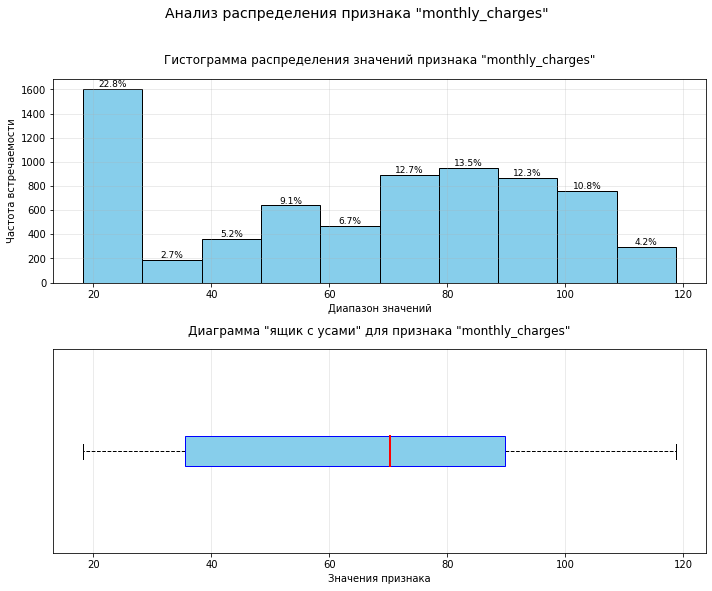


Статистический анализ признака "total_charges":
--------------------------------------------------
count   7,039.000
mean    2,115.083
std     2,111.795
min         0.000
25%       437.500
50%     1,343.350
75%     3,236.690
max     9,221.380
Name: total_charges, dtype: float64



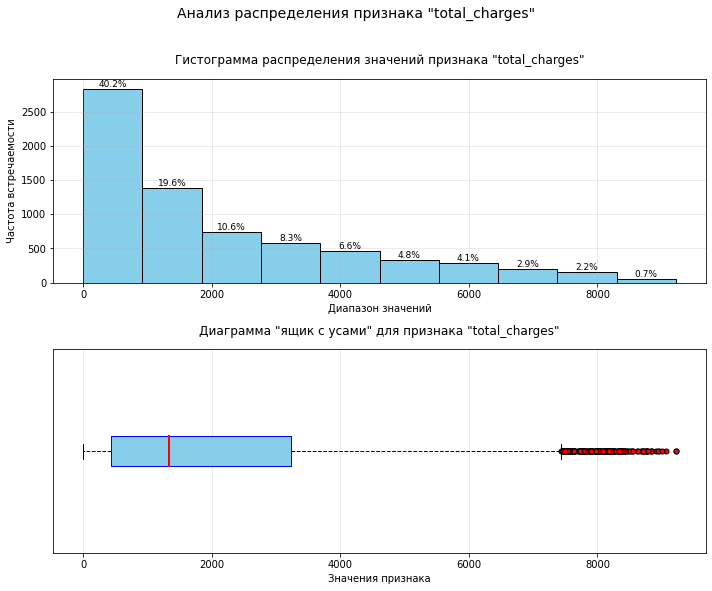


Статистический анализ признака "contract_duration_days":
--------------------------------------------------
count   7,039.000
mean      898.435
std       682.821
min         0.000
25%       276.000
50%       761.000
75%     1,461.000
max     2,314.000
Name: contract_duration_days, dtype: float64



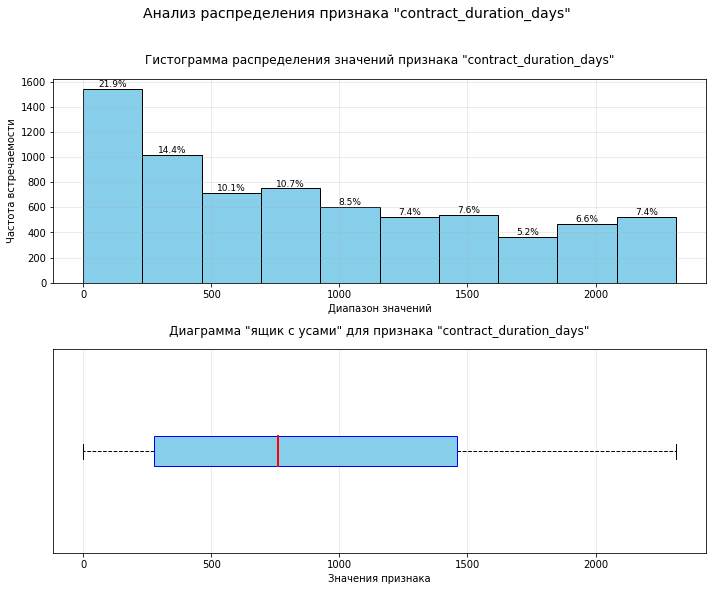


Статистический анализ признака "internet_services_count":
--------------------------------------------------
count   7,039.000
mean        2.038
std         1.847
min         0.000
25%         0.000
50%         2.000
75%         3.000
max         6.000
Name: internet_services_count, dtype: float64



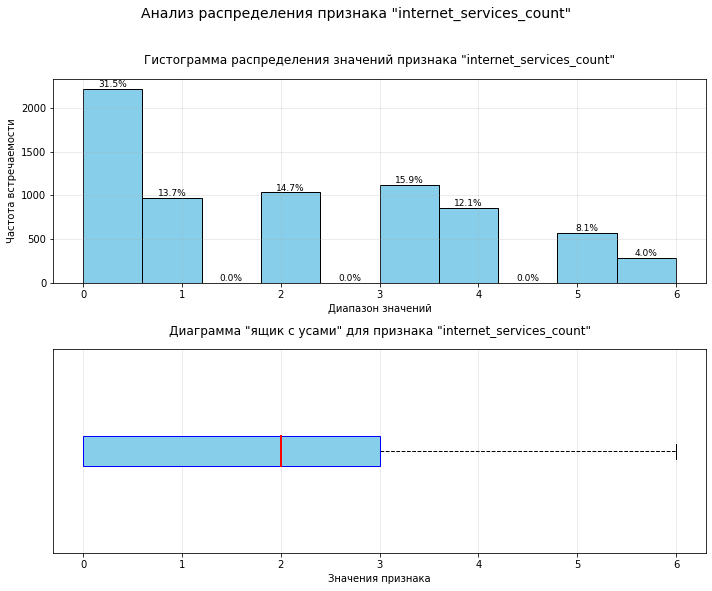

In [62]:
plot_numeric_features(df)

Вывод:

1. monthly_charges
- высокое стандартное отклонение,
- выраженный пик в диапазоне от мин.значения (18.250 до примерно 30), далее большой массив значений от 70 до 110,
- не смотря на пик у мин.значения, медиана смещена в сторону высоких значений,
- выбросов нет.

2. total_charges
- очень высокое стандартное отклонение - практически равно среднему,
- большинство значений в одном столбце - от 0 до 1000. Далее график убывает.
- медиана смещена в сторону первого квантиля, всё что выше примерно 7500 помечено выбросами (редкие значения).

3. contract_duration_days
- высокое стандартное отклонение,
- выраженный пик от 0 до 250, далее почти равномерное распределение,
- медиана немногосмещена к первому квартилю,
- выбросов нет.

4. internet_services_count  количество подключенных интернет услуг:
- 31,5% не имеют подключенных интернет-услуг.


Анализ признака "type":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
Month-to-month    3873
Two year          1693
One year          1473
Name: type, dtype: int64

Доля топ-категории: 55.0%



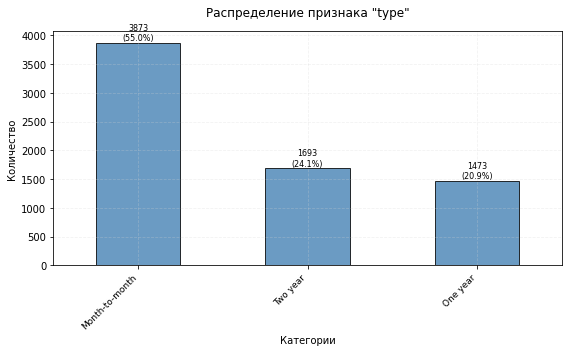


Анализ признака "paperless_billing":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
True     4170
False    2869
Name: paperless_billing, dtype: int64

Доля топ-категории: 59.2%



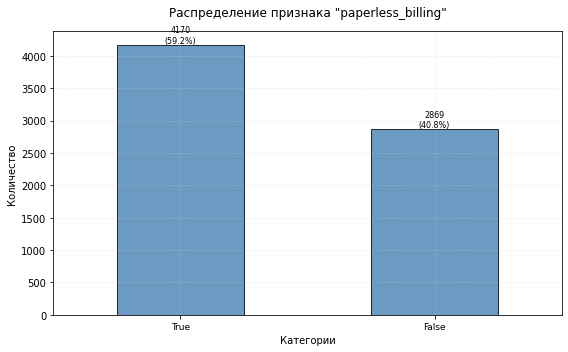


Анализ признака "payment_method":
--------------------------------------------------
Уникальных категорий: 4
Топ-5 категорий:
Electronic check             2365
Mailed check                 1609
Bank transfer (automatic)    1544
Credit card (automatic)      1521
Name: payment_method, dtype: int64

Доля топ-категории: 33.6%



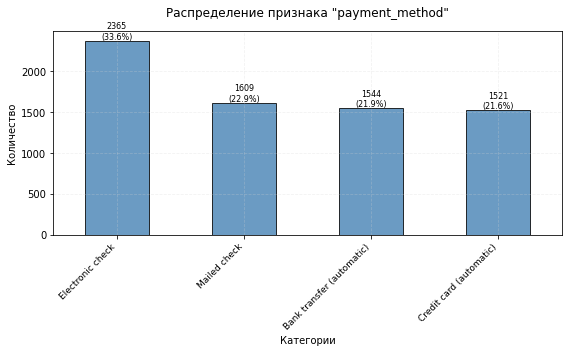


Анализ признака "gender":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
Male      3552
Female    3487
Name: gender, dtype: int64

Доля топ-категории: 50.5%



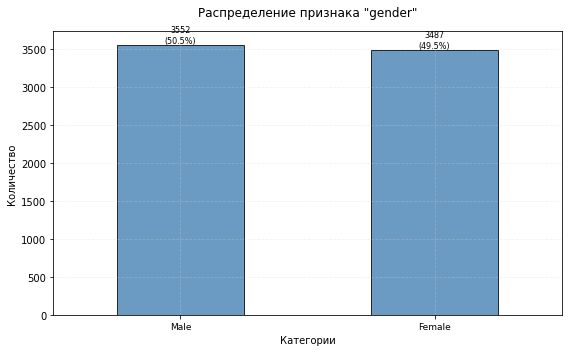


Анализ признака "senior_citizen":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
False    5897
True     1142
Name: senior_citizen, dtype: int64

Доля топ-категории: 83.8%



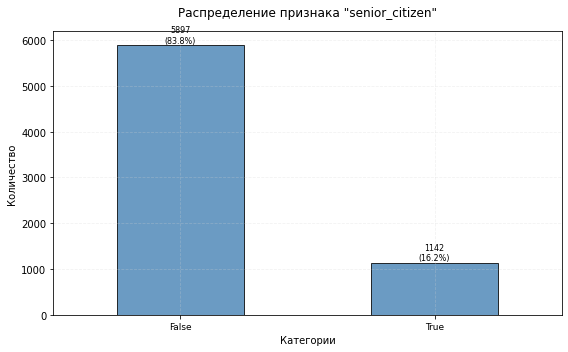


Анализ признака "partner":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
False    3639
True     3400
Name: partner, dtype: int64

Доля топ-категории: 51.7%



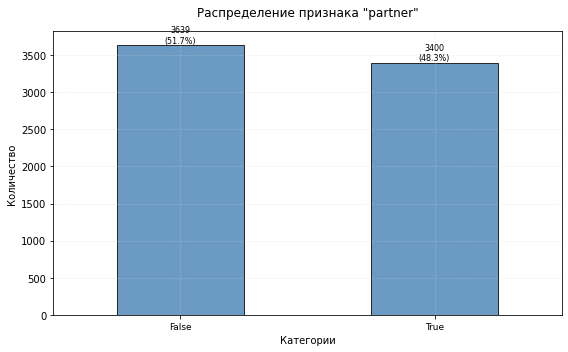


Анализ признака "dependents":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
False    4930
True     2109
Name: dependents, dtype: int64

Доля топ-категории: 70.0%



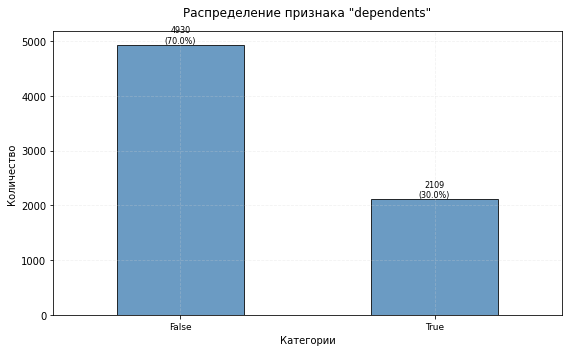


Анализ признака "internet_service":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
Fiber optic      3095
DSL              2421
not_available    1523
Name: internet_service, dtype: int64

Доля топ-категории: 44.0%



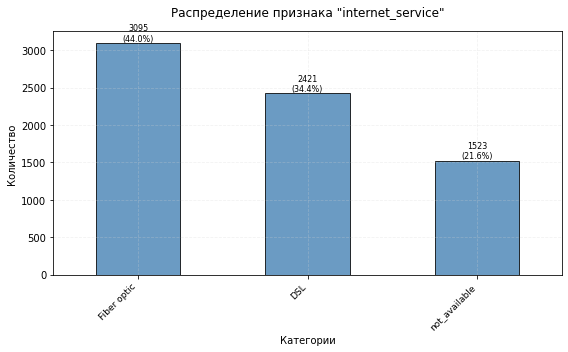


Анализ признака "online_security":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
No               3498
Yes              2018
not_available    1523
Name: online_security, dtype: int64

Доля топ-категории: 49.7%



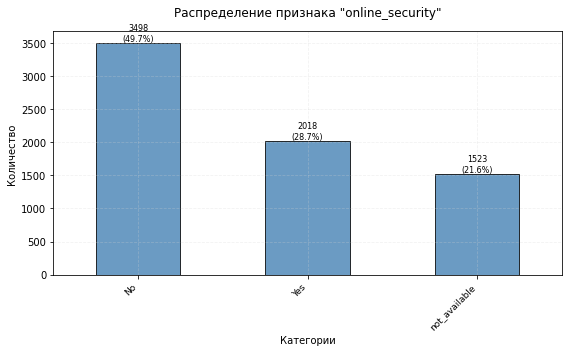


Анализ признака "online_backup":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
No               3088
Yes              2428
not_available    1523
Name: online_backup, dtype: int64

Доля топ-категории: 43.9%



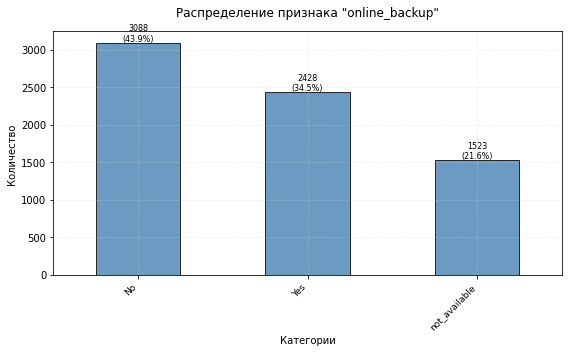


Анализ признака "device_protection":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
No               3095
Yes              2421
not_available    1523
Name: device_protection, dtype: int64

Доля топ-категории: 44.0%



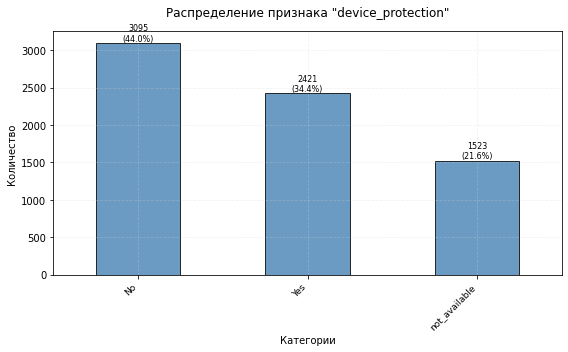


Анализ признака "tech_support":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
No               3473
Yes              2043
not_available    1523
Name: tech_support, dtype: int64

Доля топ-категории: 49.3%



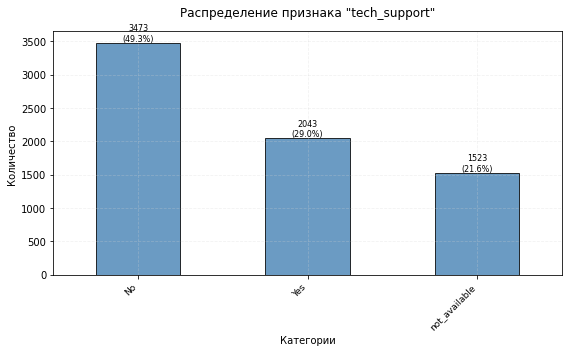


Анализ признака "streaming_tv":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
No               2810
Yes              2706
not_available    1523
Name: streaming_tv, dtype: int64

Доля топ-категории: 39.9%



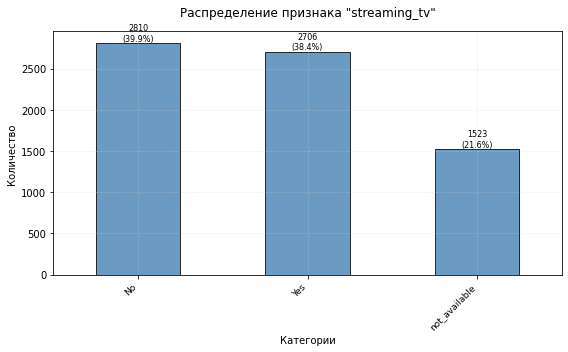


Анализ признака "streaming_movies":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
No               2785
Yes              2731
not_available    1523
Name: streaming_movies, dtype: int64

Доля топ-категории: 39.6%



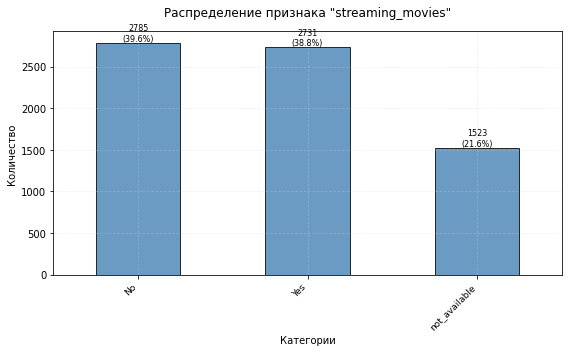


Анализ признака "multiple_lines":
--------------------------------------------------
Уникальных категорий: 3
Топ-5 категорий:
No               3388
Yes              2969
not_available     682
Name: multiple_lines, dtype: int64

Доля топ-категории: 48.1%



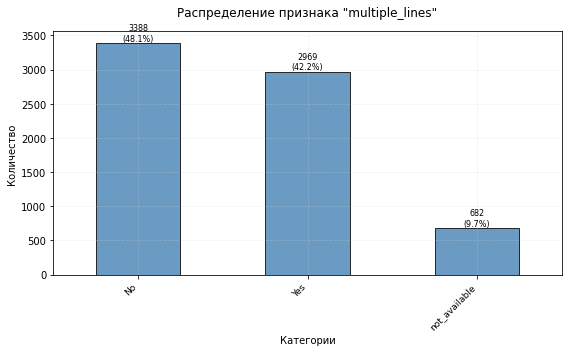


Анализ признака "is_active":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
True     5938
False    1101
Name: is_active, dtype: int64

Доля топ-категории: 84.4%



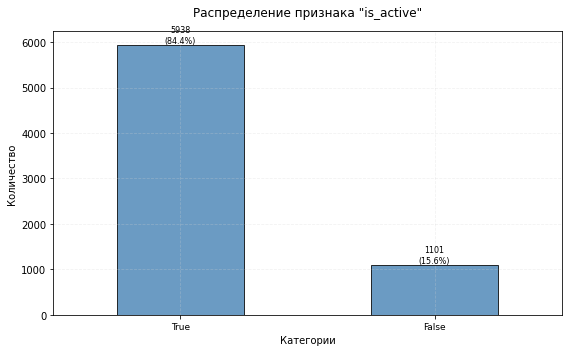


Анализ признака "has_internet":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
True     5516
False    1523
Name: has_internet, dtype: int64

Доля топ-категории: 78.4%



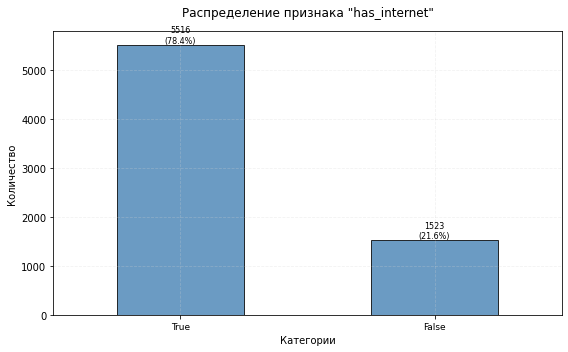


Анализ признака "is_female":
--------------------------------------------------
Уникальных категорий: 2
Топ-5 категорий:
False    3552
True     3487
Name: is_female, dtype: int64

Доля топ-категории: 50.5%



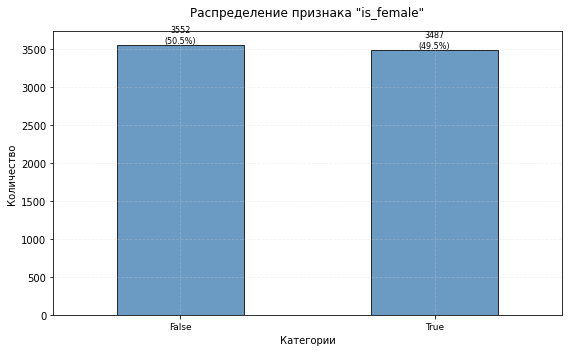

In [63]:
plot_categorical_features(df)

Вывод:

1. Type — тип оплаты: 
- 55% клиентов платят раз в месяц, 24,1% раз в 2 года, 20,9% раз в год.

2. PaperlessBilling — электронный расчётный лист:
- 59,2% клиентов получает электронный расчет лист, 40,8% - бумажный.

3. PaymentMethod — тип платежа:
- 33,6% клиентов получают electrinic check, остальные варианты имеют практичеси одинаковую долю чуть больше 20% каждый.

4. gender — пол:
- 50,5% мужчин, 49,5% женщин.

5. SeniorCitizen — является ли абонент пенсионером:
- 83,8% не являются пенсионерами.

6. Partner — есть ли у абонента супруг или супруга:
- 51,7% - не состоит в браке.

7. Dependents — есть ли у абонента дети:
- 70% не имеет детей.

8. InternetService — тип подключения:
- 44% fiber optic, 34,4% DSL, 21,7% не имеют подключения к интернету.

9. OnlineSecurity — блокировка опасных сайтов:
- 49,7% не используют.

10. OnlineBackup — облачное хранилище файлов для резервного копирования данных:
- 43,8% не используют.

11. DeviceProtection — антивирус:
- 43,9% не используют.

12. TechSupport — выделенная линия технической поддержки:
- 49,3% не используют.

13. StreamingTV — стриминговое телевидение:
- 39,9% не используют, 38,4% используют.

14. StreamingMovies — каталог фильмов.
- 39,5% не используют, 38,8% используют.

15. MultipleLines — подключение телефона к нескольким линиям одновременно:
- 48,1% не используют, 42,2% используют.

16. is_active - действует ли договор (целевой признак)
- существенные дисбаланс целевого признака: 
- 84,4% активных договора против 15,6% не активных

17. has_internet - наличие интернета:
- 78,3% имеют интернет.


Анализ временного признака: begin_date
------------------------------------------------------------
Период покрытия данных: 2013-10-01 — 2020-02-01
Всего записей: 7,039
Месяцев с данными: 77

Статистика по датам:
count                             7039
mean     2017-04-30 14:27:23.756215040
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: begin_date, dtype: object



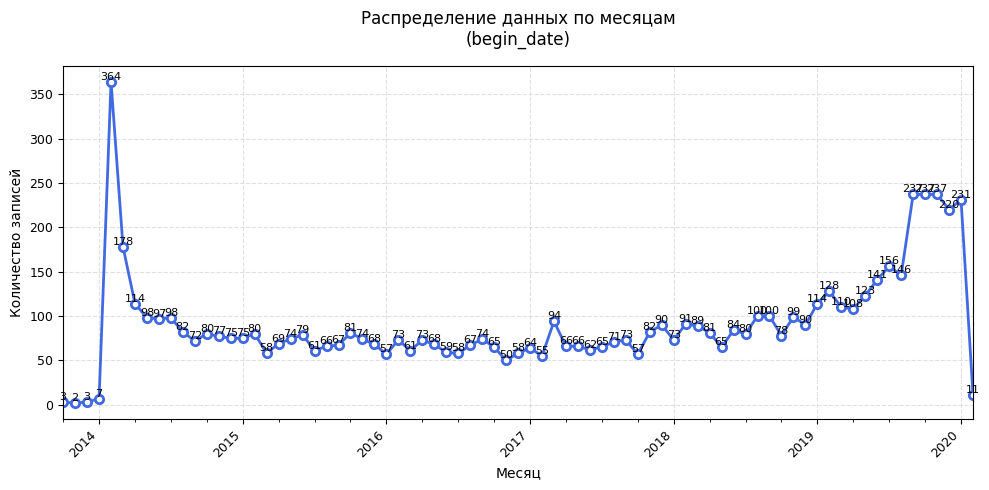


Анализ временного признака: end_date
------------------------------------------------------------
Период покрытия данных: 2014-06-01 — 2020-01-01
Всего записей: 1,101
Месяцев с данными: 66

Статистика по датам:
count                             1101
mean     2018-03-12 18:21:15.204359680
min                2014-06-01 00:00:00
25%                2017-05-01 00:00:00
50%                2018-06-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-01-01 00:00:00
Name: end_date, dtype: object



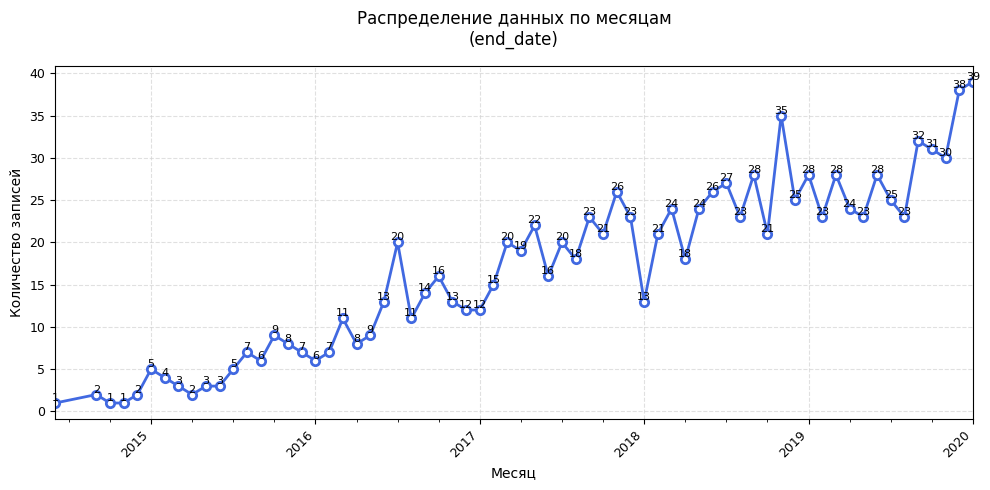

In [64]:
plot_datetime_features(df)

Вывод:
- график begin_date практически равномерный, с двумя пиками в начале и конце исследуемого периода.
- график end_date имеет восходящу тенденцию: с течением времени количество расторгнутых контарктов растет.
- сезонность не выявлена.

### Анализ распределения признаков по классам

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7039 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              7039 non-null   object        
 1   begin_date               7039 non-null   datetime64[ns]
 2   end_date                 1101 non-null   datetime64[ns]
 3   type                     7039 non-null   object        
 4   paperless_billing        7039 non-null   bool          
 5   payment_method           7039 non-null   object        
 6   monthly_charges          7039 non-null   float64       
 7   total_charges            7039 non-null   float64       
 8   gender                   7039 non-null   object        
 9   senior_citizen           7039 non-null   bool          
 10  partner                  7039 non-null   bool          
 11  dependents               7039 non-null   bool          
 12  internet_service         7039 non-

In [66]:
# визуализация
def plot_feature_distributions(df, target='is_active', exclude=[]):
    for col in df.columns:
        if col in exclude or col == target:
            continue

        plt.figure(figsize=(8, 4))

        if pd.api.types.is_bool_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            # Категориальные и булевы — столбчатая диаграмма
            sns.countplot(data=df, x=col, hue=target)
            plt.title(f'Категориальное распределение: {col} vs {target}')
            plt.xticks(rotation=45)

        elif pd.api.types.is_numeric_dtype(df[col]):
            # Числовые — гистограмма
            sns.histplot(data=df, x=col, hue=target, kde=True, element='step', stat='density', common_norm=False)
            plt.title(f'Числовое распределение: {col} vs {target}')

        else:
            plt.close()  # Пропускаем неподходящие типы
            continue

        plt.tight_layout()
        plt.show()


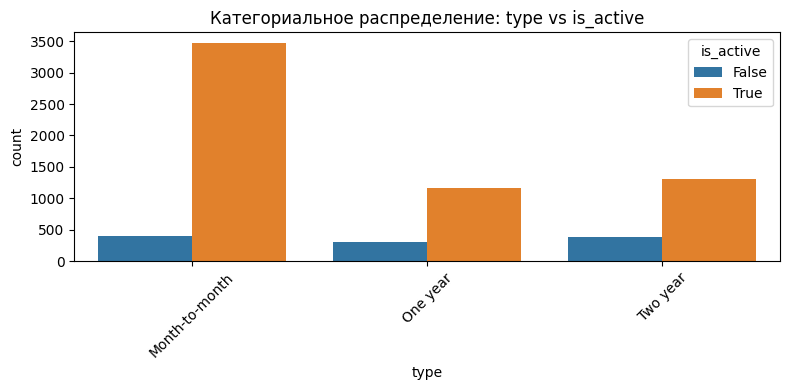

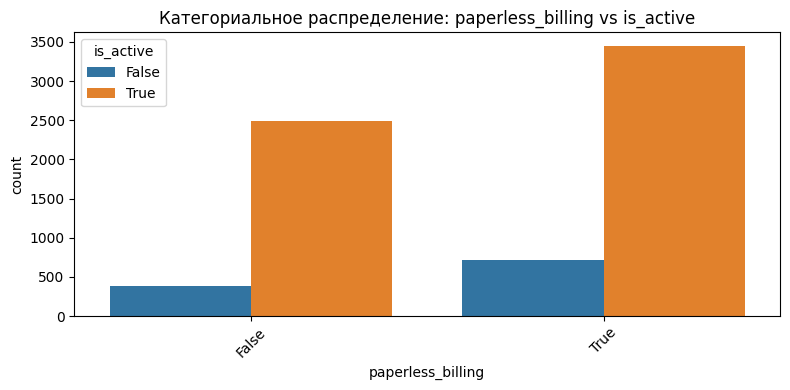

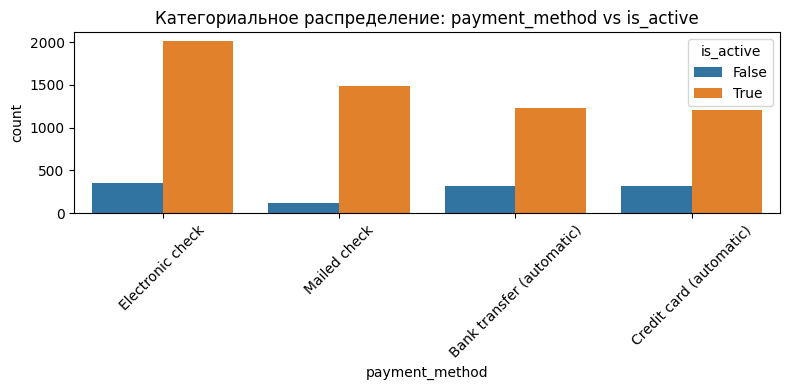

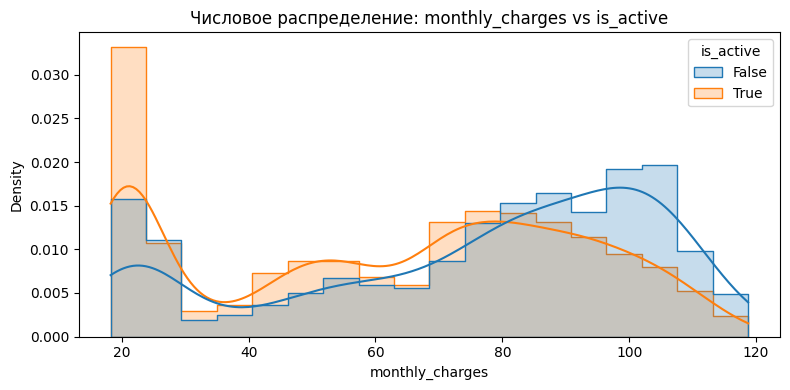

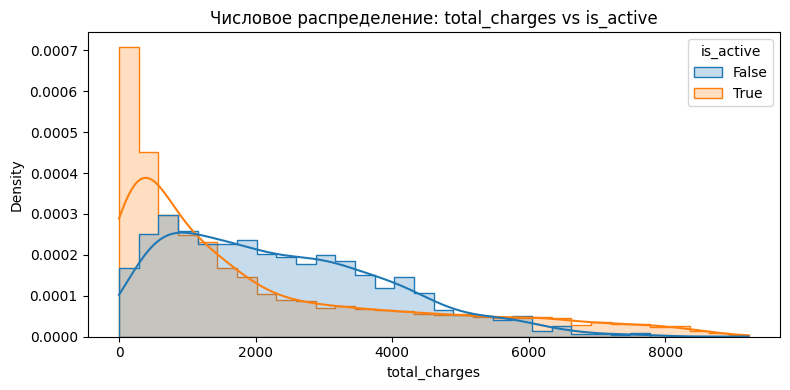

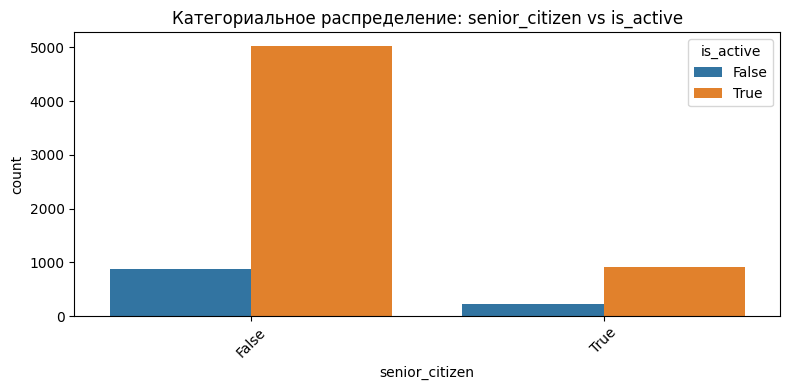

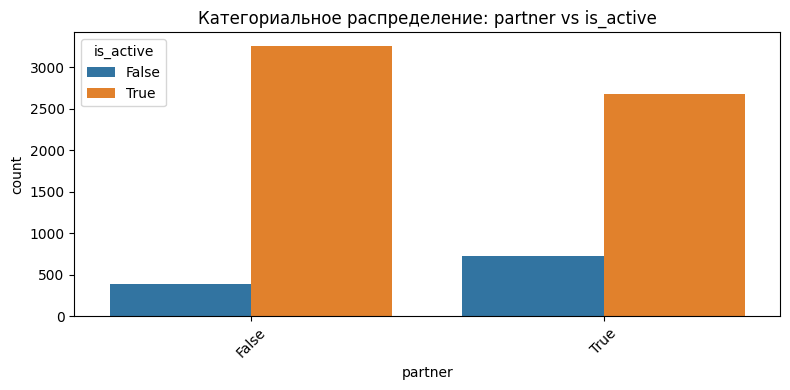

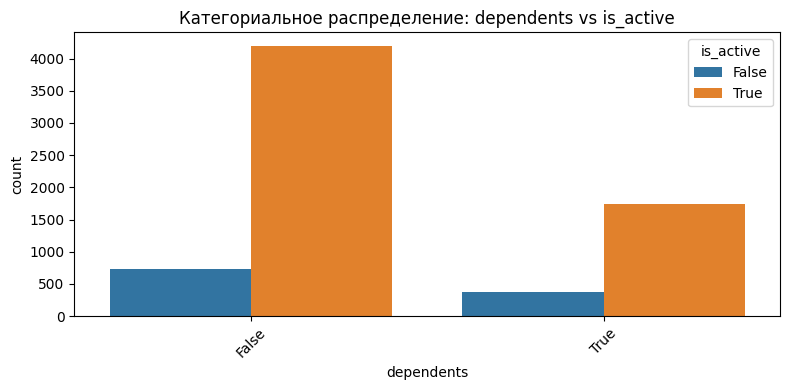

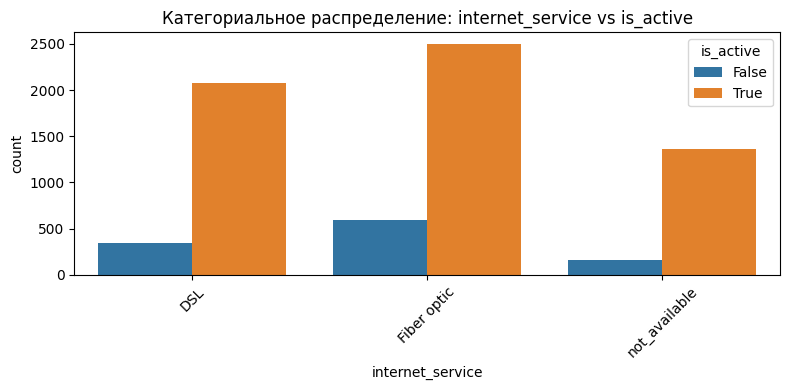

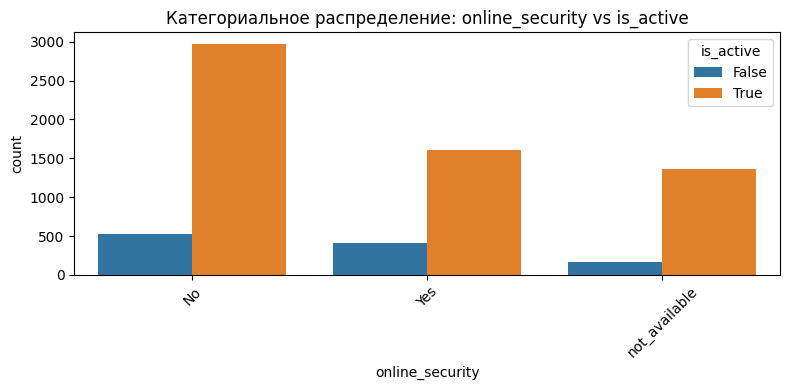

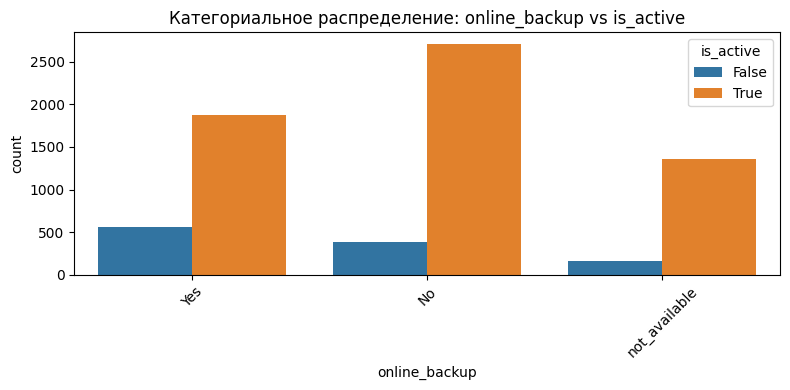

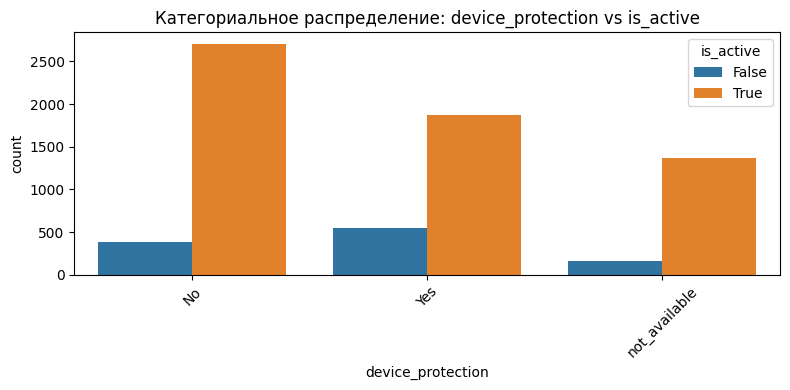

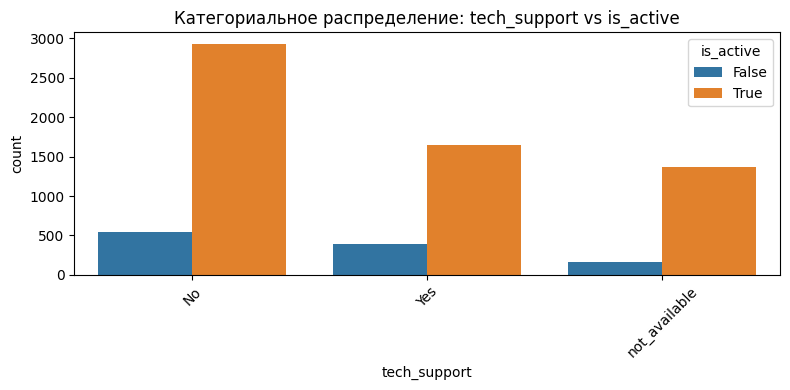

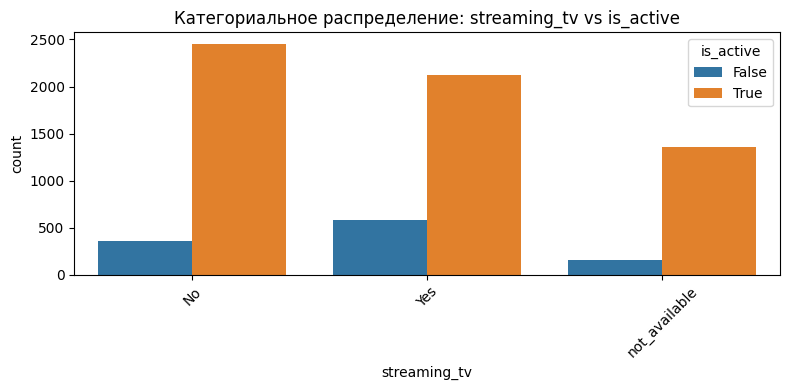

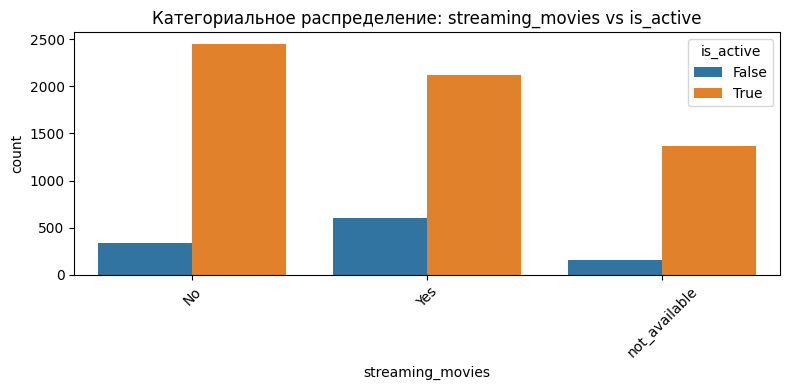

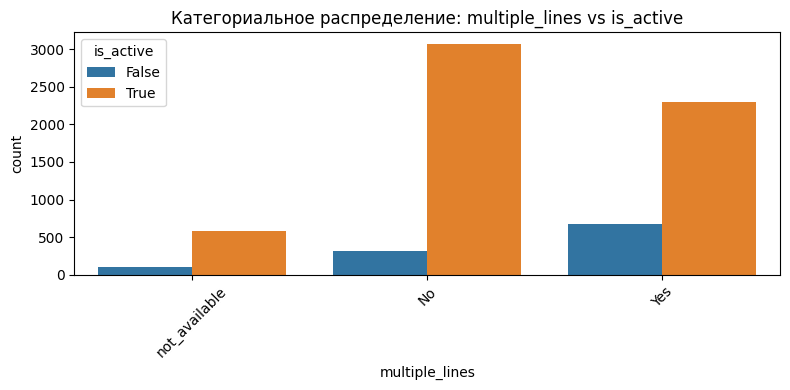

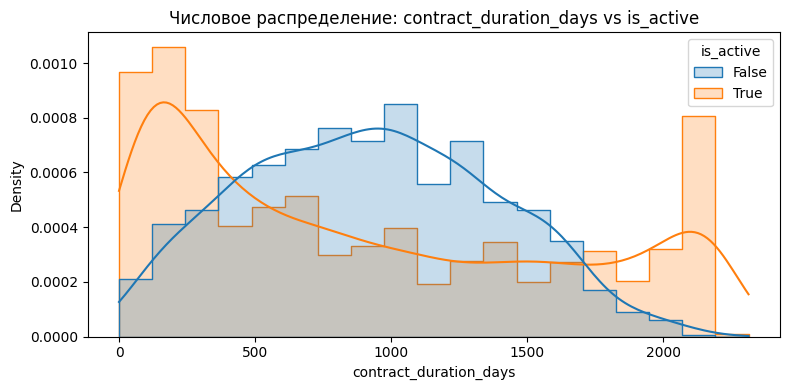

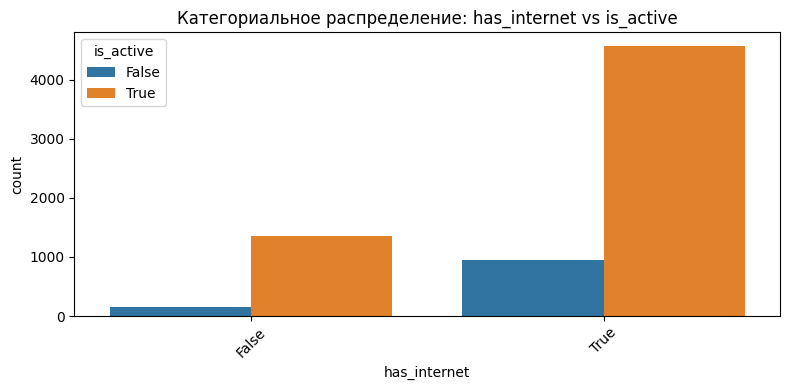

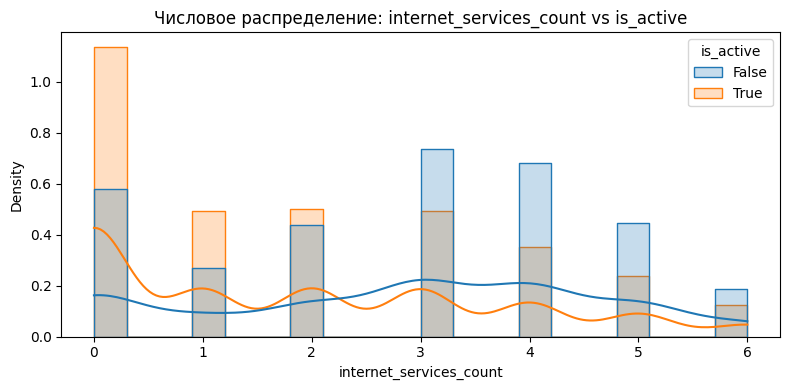

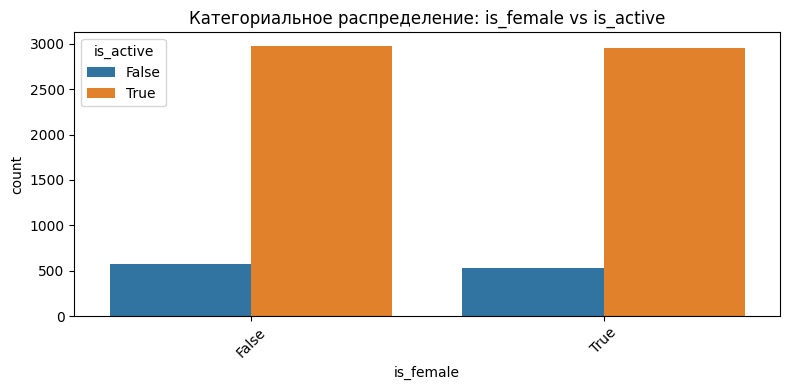

In [67]:
# Исключаем customer_id, begin_date, end_date которые не подходят для анализа в таком виде 
# Исключаем gender (т.к. создали новый признак)

plot_feature_distributions(df, target='is_active', exclude=['customer_id', 'begin_date', 'end_date', 'gender'])

In [68]:
def analyze_features(df, target_column='is_active'):

    exclude_columns = ['customer_id', 'gender', 'begin_date', 'end_date'] # Столбцы для исключения

    for column in df.columns:
        if column in exclude_columns or column == target_column:
            continue

        print(f"\n--- {column} ---")

        if pd.api.types.is_numeric_dtype(df[column]):
            # Числовые признаки: среднее и стандартное отклонение по классам
            print(df.groupby(target_column)[column].agg(['mean', 'std']))
        else:
            # Категориальные признаки: количество и процент по классам
            cross_tab = pd.crosstab(df[column], df[target_column])
            percentage_cross_tab = pd.crosstab(df[column], df[target_column], normalize='columns') * 100
            print("Counts:\n", cross_tab)
            print("\nPercentages:\n", percentage_cross_tab)

# вызов
analyze_features(df)


--- type ---
Counts:
 is_active       False  True 
type                        
Month-to-month    407   3466
One year          313   1160
Two year          381   1312

Percentages:
 is_active       False  True 
type                        
Month-to-month 36.966 58.370
One year       28.429 19.535
Two year       34.605 22.095

--- paperless_billing ---
           mean   std
is_active            
False     0.655 0.476
True      0.581 0.493

--- payment_method ---
Counts:
 is_active                  False  True 
payment_method                         
Bank transfer (automatic)    317   1227
Credit card (automatic)      317   1204
Electronic check             350   2015
Mailed check                 117   1492

Percentages:
 is_active                  False  True 
payment_method                         
Bank transfer (automatic) 28.792 20.664
Credit card (automatic)   28.792 20.276
Electronic check          31.789 33.934
Mailed check              10.627 25.126

--- monthly_charges ---
    

Вывод:

1. **Тип контракта**:
   - **Месячные контракты** дают 58% активных клиентов, но и 37% оттока — самый рискованный тип.
   - **Двухлетние контракты** стабильнее (22% активных, 35% оттока).

2. **Платежи и услуги**:
   - **Электронные чеки** — 34% оттока (максимум среди платежных методов).
   - **Fiber optic** интернет — 54% оттока против 31% у DSL.
   - Клиенты **без дополнительных услуг** (security/backup) уходят чаще (47-50% оттока).

3. **Финансовые показатели**:
   - Ушедшие клиенты платят **больше** (`monthly_charges`: 75.5 vs 62.8 у активных).
   - **Total_charges** выше у неактивных (2371 vs 2067), но с большим разбросом.

4. **Демография**:
   - **Пенсионеры** уходят чаще (21% vs 15% у остальных).
   - Клиенты **без партнера/детей** лояльнее (отток 10-15%).

5. **Прочие факторы**:
   - **Multiple lines** — при наличии отток выше (62% vs 29% без услуги).
   - **Длительность контракта** почти не влияет (разница в mean: 924 vs 893 дней).

### Корреляция


In [69]:
def plot_phik_matrix(df, exclude=[]):
    df_phik = df.drop(columns=exclude)
    interval_cols = df_phik.select_dtypes(include=['float64', 'int64']).columns.tolist()
    phik_corr = df_phik.phik_matrix(interval_cols=interval_cols)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(phik_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
    plt.title('Матрица φk-корреляции (Phik)')
    plt.tight_layout()
    plt.show()


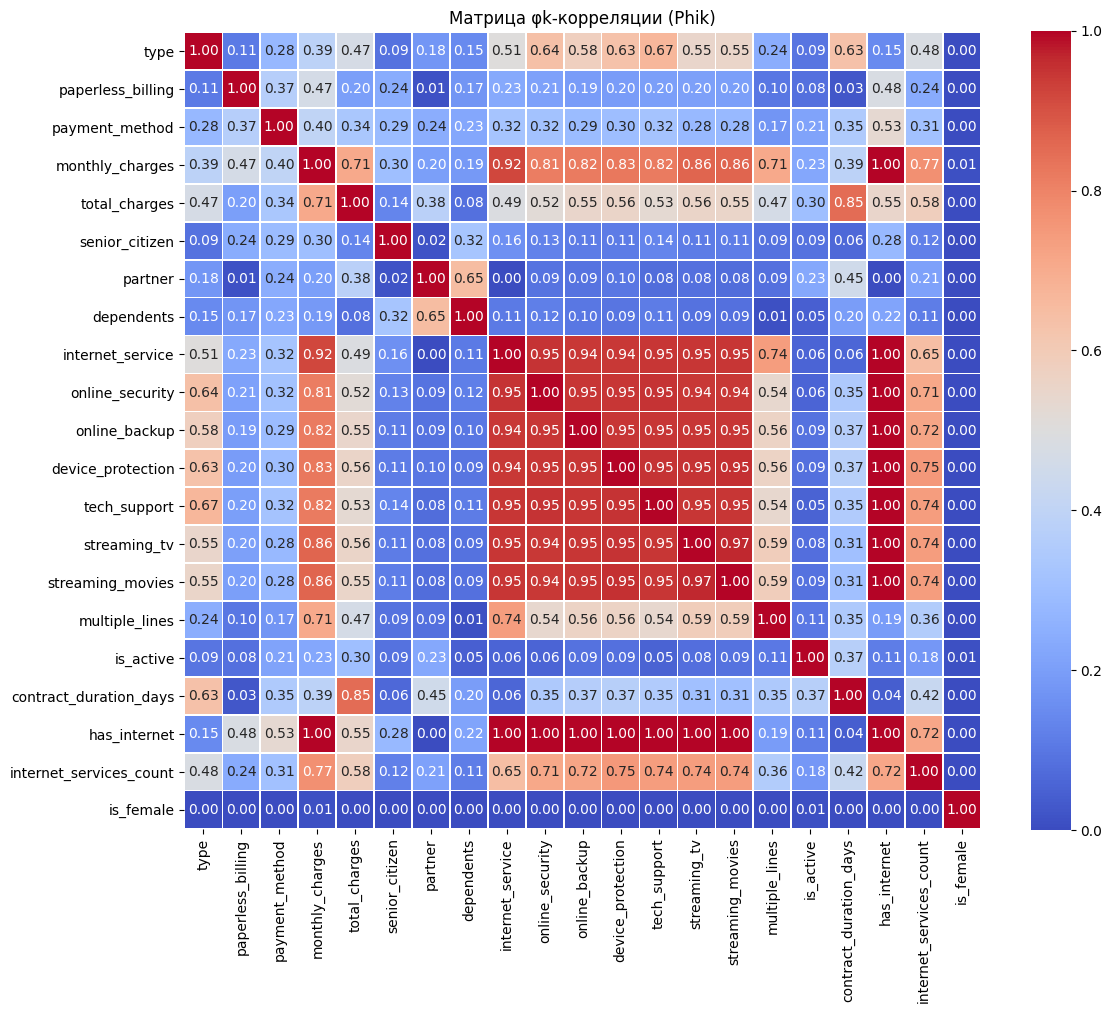

In [70]:
plot_phik_matrix(df, exclude=['customer_id', 'begin_date', 'end_date', 'gender'])

Вывод:
1. Мультиколлинеарность has_internet и monthly_charges. Поэтому has_internet не будем использовать в модели.
2. Все признаки интернет-услуг мультиколлинеарны. Не будем их использовать в модели, так как ранее мы создали новый признак - количество интернет-услуг.
3. Утечка целевого признака не обнаружена.

Общий вывод анализа данных:

- Серьезный дисбаланс целевого признака: 84.4% активных vs 15.6% неактивных контрактов. 
- Отсутствие явной сезонности.
- Числовые признаки в разном диапазоне, понадобится масштабирование.
- Категориальные признаки не содержат ранговых значений, можно использовать OneHotEncoding.
- Определен список признаков, которые будут использовны для обучения моделей.

 Данные демонстрируют выраженные паттерны, пригодные для прогнозирования оттока, но требуют балансировки или использования метрик, не чувстительных к дисбалансу (например, ROC-AUC). 

## Обучение моделей

Мы решаем задачу бинарной классификации - обучение с учителем.\
Для ее решения обучим классическую модель (LogisticRegression), 2 модели бустинга (CatBoost и LGBM) и модель бэггинга (RandomForest).

Целевая переменная - is_active.

Признаки:
все, кроме:

- customer_id, begin_date, end_date (идентификаторы и даты)
- gender (создали на его основе бинарный)
- online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies (дополнительные сервисы)
- is_active (целевая переменная)
- has_internet (флаг наличия интернета)

In [71]:
# Определение y
y = df['is_active']

# Определение X: исключаем ненужные столбцы
columns_to_drop = [
    'customer_id', 'begin_date', 'end_date', 'gender',
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies',
    'is_active', 'has_internet', 
]

X = df.drop(columns=columns_to_drop)

# Проверка оставшихся признаков в X
print(X.columns)

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'multiple_lines', 'contract_duration_days',
       'internet_services_count', 'is_female'],
      dtype='object')


In [72]:
# Разбиваем датасет на учебную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify = y, # стратификация для сохранненя пропорцй меток таргета в выборках
    random_state=RANDOM_STATE
)

In [73]:
#смотрю размеры выборок:
for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(5279, 13)
(5279,)
(1760, 13)
(1760,)


In [74]:
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train type: <class 'pandas.core.frame.DataFrame'>
y_train type: <class 'pandas.core.series.Series'>


In [75]:
print("Распределение меток в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print("\nРаспределение меток в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Распределение меток в обучающей выборке:
True    0.844
False   0.156
Name: is_active, dtype: float64

Распределение меток в тестовой выборке:
True    0.844
False   0.156
Name: is_active, dtype: float64


In [76]:
X_train.head(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,multiple_lines,contract_duration_days,internet_services_count,is_female
3598,Month-to-month,False,Electronic check,46.300,46.300,True,False,False,DSL,No,31,0,False
1080,Two year,True,Bank transfer (automatic),20.050,699.340,False,False,False,not_available,No,975,0,False


In [77]:
X_test.head(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,multiple_lines,contract_duration_days,internet_services_count,is_female
3177,Two year,False,Mailed check,48.900,"3,556.010",False,True,True,DSL,not_available,2191,4,False
5041,One year,False,Mailed check,20.650,90.030,False,True,False,not_available,No,122,0,False


In [78]:
y_train.head(2)

3598    True
1080    True
Name: is_active, dtype: bool

In [79]:
y_test.head(2)

3177     True
5041    False
Name: is_active, dtype: bool

In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5279 entries, 3598 to 3379
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type                     5279 non-null   object 
 1   paperless_billing        5279 non-null   bool   
 2   payment_method           5279 non-null   object 
 3   monthly_charges          5279 non-null   float64
 4   total_charges            5279 non-null   float64
 5   senior_citizen           5279 non-null   bool   
 6   partner                  5279 non-null   bool   
 7   dependents               5279 non-null   bool   
 8   internet_service         5279 non-null   object 
 9   multiple_lines           5279 non-null   object 
 10  contract_duration_days   5279 non-null   int64  
 11  internet_services_count  5279 non-null   int64  
 12  is_female                5279 non-null   bool   
dtypes: bool(5), float64(2), int64(2), object(4)
memory usage: 397.0+ KB


### LogisticRegression

In [81]:
# Определение числовых и категориальных признаков
numeric_features = ['monthly_charges', 'total_charges', 'contract_duration_days', 'internet_services_count']
categorical_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 
                        'partner', 'dependents', 'internet_service', 'multiple_lines', 'is_female']

In [82]:
# Препроцессинг
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)

    ])

In [83]:
# Пайплайн
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced'))
])

    # Параметры для GridSearchCV с фокусом на ROC-AUC
param_grid = {
    'classifier__C': [0.01, 0.1],  # Более детальный поиск
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'], # Только этот solver поддерживает L1
    'classifier__class_weight': ['balanced']
}

# Настройка кросс-валидации (стратифицированная)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Подбор гиперпараметров с ROC-AUC как основной метрикой
lr_grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',  # Основная метрика
    refit=True,         # Автоматически дообучит лучшую модель на всех данных
    n_jobs=-1,
    verbose=1
)

In [84]:
# Обучение с подбором параметров
lr_grid_search.fit(X_train, y_train)

# Лучшая модель
lr_best_model = lr_grid_search.best_estimator_

# Результаты кросс-валидации
print("\nЛучшие параметры:", lr_grid_search.best_params_)
print(f"Лучший ROC-AUC (CV): {lr_grid_search.best_score_:.4f}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits

Лучшие параметры: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Лучший ROC-AUC (CV): 0.7668


### CatBoostClassifier

In [85]:
# Вычисляем веса
n_class_0 = (y_train == False).sum()
n_class_1 = (y_train == True).sum()

In [86]:
param_dist = {
    'depth': randint(3, 6),  # Уменьшаем глубину
    'learning_rate': loguniform(1e-3, 0.05),
    'l2_leaf_reg': loguniform(1, 5),
    'grow_policy': ['SymmetricTree', 'Depthwise'],  # Убираем Lossguide
    'min_data_in_leaf': randint(1, 10),  # Уменьшаем для минорного класса
    #'scale_pos_weight': uniform(0.1, 1.0)  # Добавляем поиск весов
}

In [87]:
# Создаем CatBoost Pool для ускорения
train_pool = Pool(
    X_train, 
    y_train,
    cat_features=categorical_features
)

# Модель с фиксированными параметрами
model = CatBoostClassifier(
    iterations=1000,
    #auto_class_weights='Balanced',  # Альтернативный вариант
    scale_pos_weight=n_class_0/n_class_1,
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    early_stopping_rounds=100,
    verbose=0
)

# RandomizedSearchCV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
cb_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # Количество комбинаций
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=3
)

# Запуск поиска
cb_search.fit(X_train, y_train, cat_features=categorical_features)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END depth=5, grow_policy=Depthwise, l2_leaf_reg=2.095513620933119, learning_rate=0.003530946112550875, min_data_in_leaf=9; total time=   9.0s
[CV 2/10] END depth=5, grow_policy=Depthwise, l2_leaf_reg=2.095513620933119, learning_rate=0.003530946112550875, min_data_in_leaf=9; total time=   8.2s
[CV 3/10] END depth=5, grow_policy=Depthwise, l2_leaf_reg=2.095513620933119, learning_rate=0.003530946112550875, min_data_in_leaf=9; total time=   7.6s
[CV 4/10] END depth=5, grow_policy=Depthwise, l2_leaf_reg=2.095513620933119, learning_rate=0.003530946112550875, min_data_in_leaf=9; total time=   7.6s
[CV 5/10] END depth=5, grow_policy=Depthwise, l2_leaf_reg=2.095513620933119, learning_rate=0.003530946112550875, min_data_in_leaf=9; total time=   7.4s
[CV 6/10] END depth=5, grow_policy=Depthwise, l2_leaf_reg=2.095513620933119, learning_rate=0.003530946112550875, min_data_in_leaf=9; total time=   7.7s
[CV 7/10] END depth=5, gr

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=210425, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f3f10625220>,
                   n_jobs=-1,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3e511e2790>,
                                        'grow_policy': ['SymmetricTree',
                                                        'Depthwise'],
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3e51143370>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f3e5112e730>,
                                        'min_data_in_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3e50f7b940>},
                   random_state=210425, scoring='roc_auc', verbose=3)

In [88]:
# Лучшая модель
cb_best_model = cb_search.best_estimator_
print(f"Лучшие параметры: {cb_search.best_params_}")
print(f"Лучший ROC-AUC (CV): {cb_search.best_score_:.4f}")

Лучшие параметры: {'depth': 3, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.5262453883861975, 'learning_rate': 0.04134380353535496, 'min_data_in_leaf': 6}
Лучший ROC-AUC (CV): 0.9112


### RandomForestClassifier

In [89]:
# Препроцессинг 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  
        # Для Random Forest масштабирование не обязательно, но без него метрика ниже
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Пайплайн 
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, 
                                       class_weight='balanced',
                                       n_jobs=-1))
])

# Параметры 
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 0.5]
}

# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Подбор гиперпараметров
rf_grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1,
    verbose=1
)

# Обучение
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=210425, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'contract_duration_days',
                                                                          'internet_services_count']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                       

In [90]:
print("Лучшие параметры:", rf_grid_search.best_params_)
print("Лучший ROC-AUC:", rf_grid_search.best_score_)

Лучшие параметры: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Лучший ROC-AUC: 0.8188646008090213


### LGBMClassifier

In [91]:
#  Создадим пайплайн с OHE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ],
    remainder='drop'  
)

# Полный пайплайн с LGBM
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        objective='binary',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1,
        class_weight='balanced'  # Автоматическая балансировка
    ))
])

# Параметры для GridSearch
param_grid = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10],
    'preprocessor__num__with_mean': [True, False]  # Опции масштабирования
}

# Обучение
lgbm_grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=2
)
lgbm_grid_search.fit(X_train, y_train)

# Оценка
lgbm_best_model = lgbm_grid_search.best_estimator_
print(f"Лучшие параметры: {lgbm_grid_search.best_params_}")
print(f"Лучший AUC-ROC: {lgbm_grid_search.best_score_:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, preprocessor__num__with_mean=True; total time=   9.8s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, preprocessor__num__with_mean=True; total time=  13.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, preprocessor__num__with_mean=True; total time=   3.9s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, preprocessor__num__with_mean=False; total time=   8.0s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, preprocessor__num__with_mean=False; total time=   9.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=100, preprocessor__num__with_mean=False; total time=  14.6s
[CV] END classifier__learning_rate=0

Мы обучили 4 модели. Уже видим, что достигли целевого значения метрики.\
Проанализируем модели на следующем этапе.

## Анализ моделей

In [92]:
# Данные для LogisticRegression
lr_data = {
    'Модель': ['LogisticRegression'],
    'Параметры': [lr_grid_search.best_params_],
    'ROC-AUC_train': [lr_grid_search.best_score_]
}

# Данные для CatBoostClassifier
cb_data = {
    'Модель': ['CatBoostClassifier'],
    'Параметры': [cb_search.best_params_],
    'ROC-AUC_train': [cb_search.best_score_]
}

# Данные для RandomForestClassifier
rf_data = {
    'Модель': ['RandomForestClassifier'],
    'Параметры': [rf_grid_search.best_params_],
    'ROC-AUC_train': [rf_grid_search.best_score_] 
}

# Данные для LGBMClassifier
lgbm_data = {
    'Модель': ['LGBMClassifier'],
    'Параметры': [lgbm_grid_search.best_params_],
    'ROC-AUC_train': [lgbm_grid_search.best_score_]
}


# Создание DataFrame для каждой модели
lr_df = pd.DataFrame(lr_data)
cb_df = pd.DataFrame(cb_data)
rf_df = pd.DataFrame(rf_data)
lgbm_df = pd.DataFrame(lgbm_data)

# Объединение DataFrame
results_df = pd.concat([lr_df, cb_df, rf_df, lgbm_df], ignore_index=True)

In [93]:
results_df

,Модель,Параметры,ROC-AUC_train
0,LogisticRegression,"{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}",0.767
1,CatBoostClassifier,"{'depth': 3, 'grow_policy': 'Depthwise', 'l2_leaf_reg': 1.5262453883861975, 'learning_rate': 0.04134380353535496, 'min_data_in_leaf': 6}",0.911
2,RandomForestClassifier,"{'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}",0.819
3,LGBMClassifier,"{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'preprocessor__num__with_mean': False}",0.870


Выбираем лучшую модель - CatBoostClassifier: у нее самая высокая метрика ROC-AUC (0,91), что удовлетворяет требованиям заказчика (не менее 0,85).

## Тестирование лучшей модели

In [94]:
test_pool = Pool(X_test, cat_features=categorical_features)

# Предсказания на тестовых данных (используем test_pool)
y_pred_proba = cb_best_model.predict_proba(test_pool)[:, 1]

# Расчет ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC на тестовых данных: {roc_auc}")

ROC AUC на тестовых данных: 0.9135304560759105


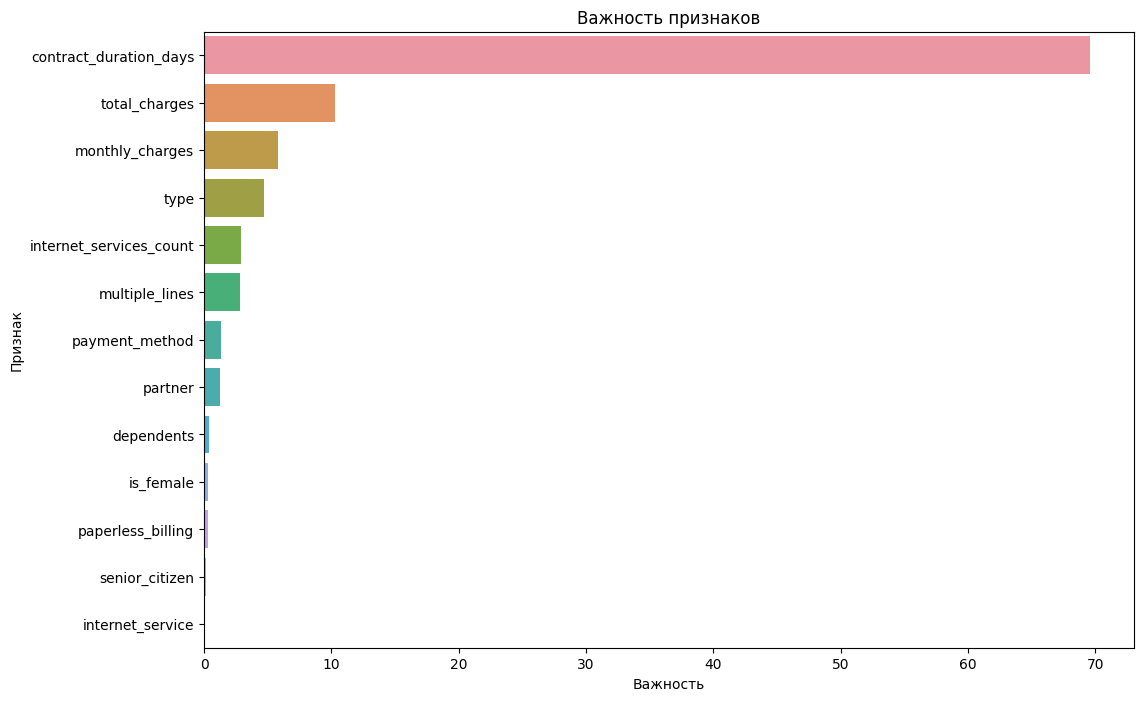

                    feature  importance
10   contract_duration_days      69.573
4             total_charges      10.294
3           monthly_charges       5.821
0                      type       4.675
11  internet_services_count       2.888
9            multiple_lines       2.794
2            payment_method       1.331
6                   partner       1.288
7                dependents       0.427
12                is_female       0.331
1         paperless_billing       0.284
5            senior_citizen       0.187
8          internet_service       0.108


In [95]:
# Получаем важность признаков
feature_importances = cb_best_model.get_feature_importance(train_pool) # Используем train_pool

# Создаем DataFrame для удобства
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns, # Названия признаков
    'importance': feature_importances
})

# Сортируем по убыванию важности
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

# Вывод в виде таблицы (опционально)
print(feature_importance_df)

In [96]:
y_pred_classes = cb_best_model.predict(test_pool)
y_pred_classes = y_pred_classes.astype(bool) # <-- Приведение типа ЗДЕСЬ
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy на тестовых данных: {accuracy}")

Accuracy на тестовых данных: 0.84375


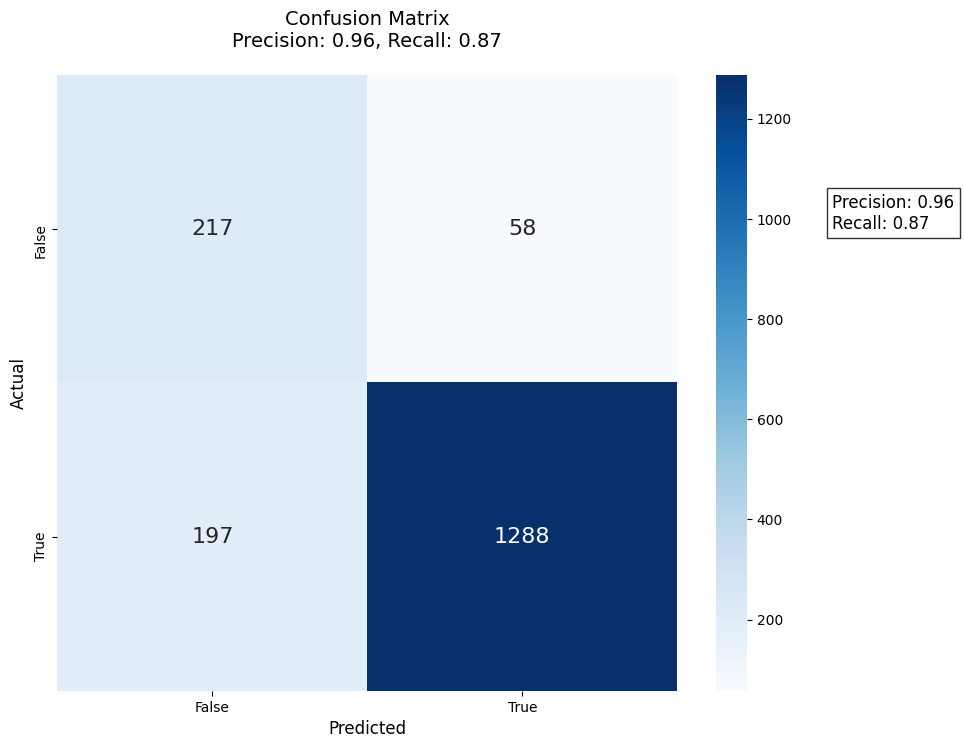

In [97]:
# 1. Получаем предсказанные вероятности
y_pred_proba = cb_best_model.predict_proba(X_test)[:, 1]  # Вероятности класса True

# 2. Определяем порог (по умолчанию 0.5)
threshold = 0.5  
y_pred_classes = (y_pred_proba >= threshold).astype(int)

# 3. Строим confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# 4. Вычисляем precision и recall
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

# 5. Визуализируем с подписями и метриками
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'],
            annot_kws={'size': 16})

# Добавляем метрики в заголовок
plt.title(f'Confusion Matrix\nPrecision: {precision:.2f}, Recall: {recall:.2f}', 
          fontsize=14, pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

# Добавляем текстовые аннотации с метриками
plt.text(2.5, 0.5, f'Precision: {precision:.2f}\nRecall: {recall:.2f}', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

Вывод:

- Модель хорошо предсказывает отток клиентов (ROC AUC 0.91, Accuracy 0.84). 

- Ключевые факторы - длительность контракта, общая и ежемесячная плата. 

- Модель чаще ошибается, предсказывая уход лояльных клиентов, что может быть приемлемо для задач удержания. 

- В целом, модель полезна, но можно улучшить полноту.

## Общий вывод по проекту

В ходе проекта была проведена комплексная работа по анализу данных и построению модели для прогнозирования оттока клиентов телекоммуникационной компании. Работа включала следующие этапы:

**1. Предобработка данных:** 

Данные из нескольких таблиц были объединены, типы данных приведены к корректным, обработаны пропуски и созданы новые признаки, такие как длительность контракта и количество интернет-услуг. Особое внимание было уделено обработке дат и денежных значений.

**2. Исследовательский анализ данных (EDA):**

EDA выявил дисбаланс классов в целевой переменной (отток клиентов), что потребовало применения стратегий балансировки при обучении моделей. Также был проведен анализ важности признаков и определен набор наиболее информативных для построения модели.

**3. Выбор и обучение моделей:** 

Были обучены и оценены несколько моделей машинного обучения, включая логистическую регрессию, CatBoost, LGBM и случайный лес. Для каждой модели был проведен подбор гиперпараметров с использованием кросс-валидации.

**4. Оценка моделей:** 

Модели были оценены по метрике ROC AUC на тренировочных данных. Лучший результат показала модель CatBoostClassifier с ROC AUC 0.91 на тестовой выборке и Accuracy 0.84, что превышает установленный заказчиком порог в 0.85.

**Результаты:**

Построенная модель CatBoostClassifier позволяет эффективно прогнозировать отток клиентов. Наиболее важными факторами, влияющими на отток, являются длительность контракта, общая и ежемесячная сумма платежей. Модель склонна чаще ошибаться в сторону предсказания оттока для лояльных клиентов, что в контексте задачи удержания может быть приемлемым компромиссом.

**Рекомендации для бизнеса:**

⦁ *Внедрение модели:* Рекомендуется интегрировать модель CatBoostClassifier в CRM-систему компании для прогнозирования оттока клиентов в режиме реального времени.

⦁ *Разработка стратегий удержания:* На основе предсказаний модели и анализа важности признаков следует разработать персонализированные предложения для клиентов, находящихся в группе риска оттока. Например, предлагать скидки, бонусы или изменение тарифного плана. Особое внимание следует уделить клиентам с коротким сроком действия контракта и высокой стоимостью услуг

⦁ *Мониторинг и обновление модели:* Важно регулярно отслеживать производительность модели и при необходимости переобучать ее на новых данных, чтобы поддерживать ее актуальность и точность.

⦁ *Сбор дополнительных данных:* Для дальнейшего повышения качества модели рекомендуется рассмотреть возможность сбора дополнительных данных о клиентах, например, об их взаимодействии со службой поддержки, использовании дополнительных услуг и обратной связи.

⦁ *Интерпретация результатов:* Несмотря на высокую эффективность модели CatBoost, важно понимать, почему она делает те или иные предсказания. Дальнейший анализ важности признаков и применение методов интерпретации моделей могут помочь выявить скрытые закономерности и улучшить бизнес-процессы. Например, если анализ покажет, что определенный тарифный план сильно коррелирует с оттоком, это может быть поводом для его пересмотра.


**Внедрение предложенных рекомендаций позволит компании снизить отток клиентов, повысить их лояльность и увеличить прибыль.**